In [1]:
!pip install xgboost --quiet

In [2]:
import warnings
warnings.simplefilter("ignore")

# data processing, compute, auto-EDA
import numpy as np
import scipy
from scipy import stats
import pandas as pd

# visualizations for EDA
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
import seaborn as sns

# data transformations
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn.preprocessing import RobustScaler
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

# model prep
from sklearn.model_selection import train_test_split

# models
from sklearn.linear_model import LinearRegression # also: Stacking Method's meta learner
from sklearn.ensemble import ExtraTreesRegressor
## Ensemble methods
from sklearn.ensemble import RandomForestRegressor # Bagging and StackingMethod's base model 
from sklearn.ensemble import GradientBoostingRegressor # Boosting
import xgboost as xgb # Boosting
from sklearn.ensemble import StackingRegressor 
from sklearn.tree import DecisionTreeRegressor # StackingMethod's base model
from sklearn.svm import SVR # Stacking Method's base model

# performance metrics
from sklearn.metrics import mean_squared_error

# model optimization strategies
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# stacking models
from sklearn.ensemble import StackingRegressor

The following analysis is framed around this notebook: https://www.kaggle.com/code/angqx95/data-science-workflow-top-2-with-tuning

# The Data

In [3]:
# This has been processed in another notebook: https://www.kaggle.com/code/mindyng/revamp-of-lyft-ba-assignment
df_driver = pd.read_csv('/kaggle/input/lyft-analysis/df_driver.csv')
df_driver.drop(columns=['Unnamed: 0'],inplace=True)
df_driver.head()

,driver_id,driver_onboard_month,driver_onboard_day,driver_onboard_week,avg_ride_distance_mil,avg_ride_duration_sec,most_accepted_at_hour,most_accepted_at_dow,most_accepted_at_week,most_accepted_at_month,...,evening_driver,avg_next_ride_lag,unique_drive_days,avg_driving_period,avg_dormant_days,churn,average_ride_val,average_ride_freq,average_val,ltv
0,5cf93f7d1d3a8f0cf395c84053c31b1b,4,23,16,4.931888,918.214286,19,1,16,4,...,0,16.476190,7,39.0,25.0,1.0,3.786554,4.000000,15.146215,15171.293052
1,779747a77c043096f6428413f26d25dc,5,11,19,4.068912,851.789767,22,5,22,6,...,0,64.557789,40,44.0,2.0,0.0,0.484269,5.875000,2.845080,2849.790879
2,8902cda459f8ac02c38efb2815cf4026,4,8,14,3.584537,886.837005,16,1,18,4,...,0,25.644444,11,28.0,51.0,1.0,1.883792,5.090909,9.590213,9606.092363
3,8c38fce0915fbb7d816e19c3ecda64fb,4,22,16,2.444053,786.419355,21,6,25,4,...,0,40.769231,6,65.0,0.0,0.0,2.645547,5.166667,13.668661,13691.292604
4,9a2b695c70ad62abcb4323d7e9a4b6cb,4,6,14,3.622890,791.124942,20,3,14,4,...,0,133.875000,15,23.0,58.0,1.0,0.956033,3.133333,2.995569,3000.528795


In [4]:
df_driver.shape

(837, 26)

# Understanding the Data

In [5]:
# Checking for NULL's
df_driver.isnull().sum()

driver_id                 0
driver_onboard_month      0
driver_onboard_day        0
driver_onboard_week       0
avg_ride_distance_mil     0
avg_ride_duration_sec     0
most_accepted_at_hour     0
most_accepted_at_dow      0
most_accepted_at_week     0
most_accepted_at_month    0
avg_time_to_arrive        0
avg_time_to_drop_off      0
ride_count                0
avg_ride_fare             0
driver_income             0
weekday_driver            0
evening_driver            0
avg_next_ride_lag         1
unique_drive_days         0
avg_driving_period        0
avg_dormant_days          0
churn                     0
average_ride_val          0
average_ride_freq         0
average_val               0
ltv                       0
dtype: int64

In [6]:
# This most likely is the last entry ordered by timestamp in ride timestamp dataset
df_driver[df_driver['avg_next_ride_lag'].isnull()]

,driver_id,driver_onboard_month,driver_onboard_day,driver_onboard_week,avg_ride_distance_mil,avg_ride_duration_sec,most_accepted_at_hour,most_accepted_at_dow,most_accepted_at_week,most_accepted_at_month,...,evening_driver,avg_next_ride_lag,unique_drive_days,avg_driving_period,avg_dormant_days,churn,average_ride_val,average_ride_freq,average_val,ltv
574,7b625f643d0775f0ac4898e33235377b,4,4,14,2.049489,570.666667,18,2,16,4,...,0,NaN,3,15.0,68.0,1.0,2.854589,1.0,2.854589,2859.315869


In [7]:
df_driver2 = df_driver.drop(columns=['driver_id', 'churn'])

## Univariate Analysis

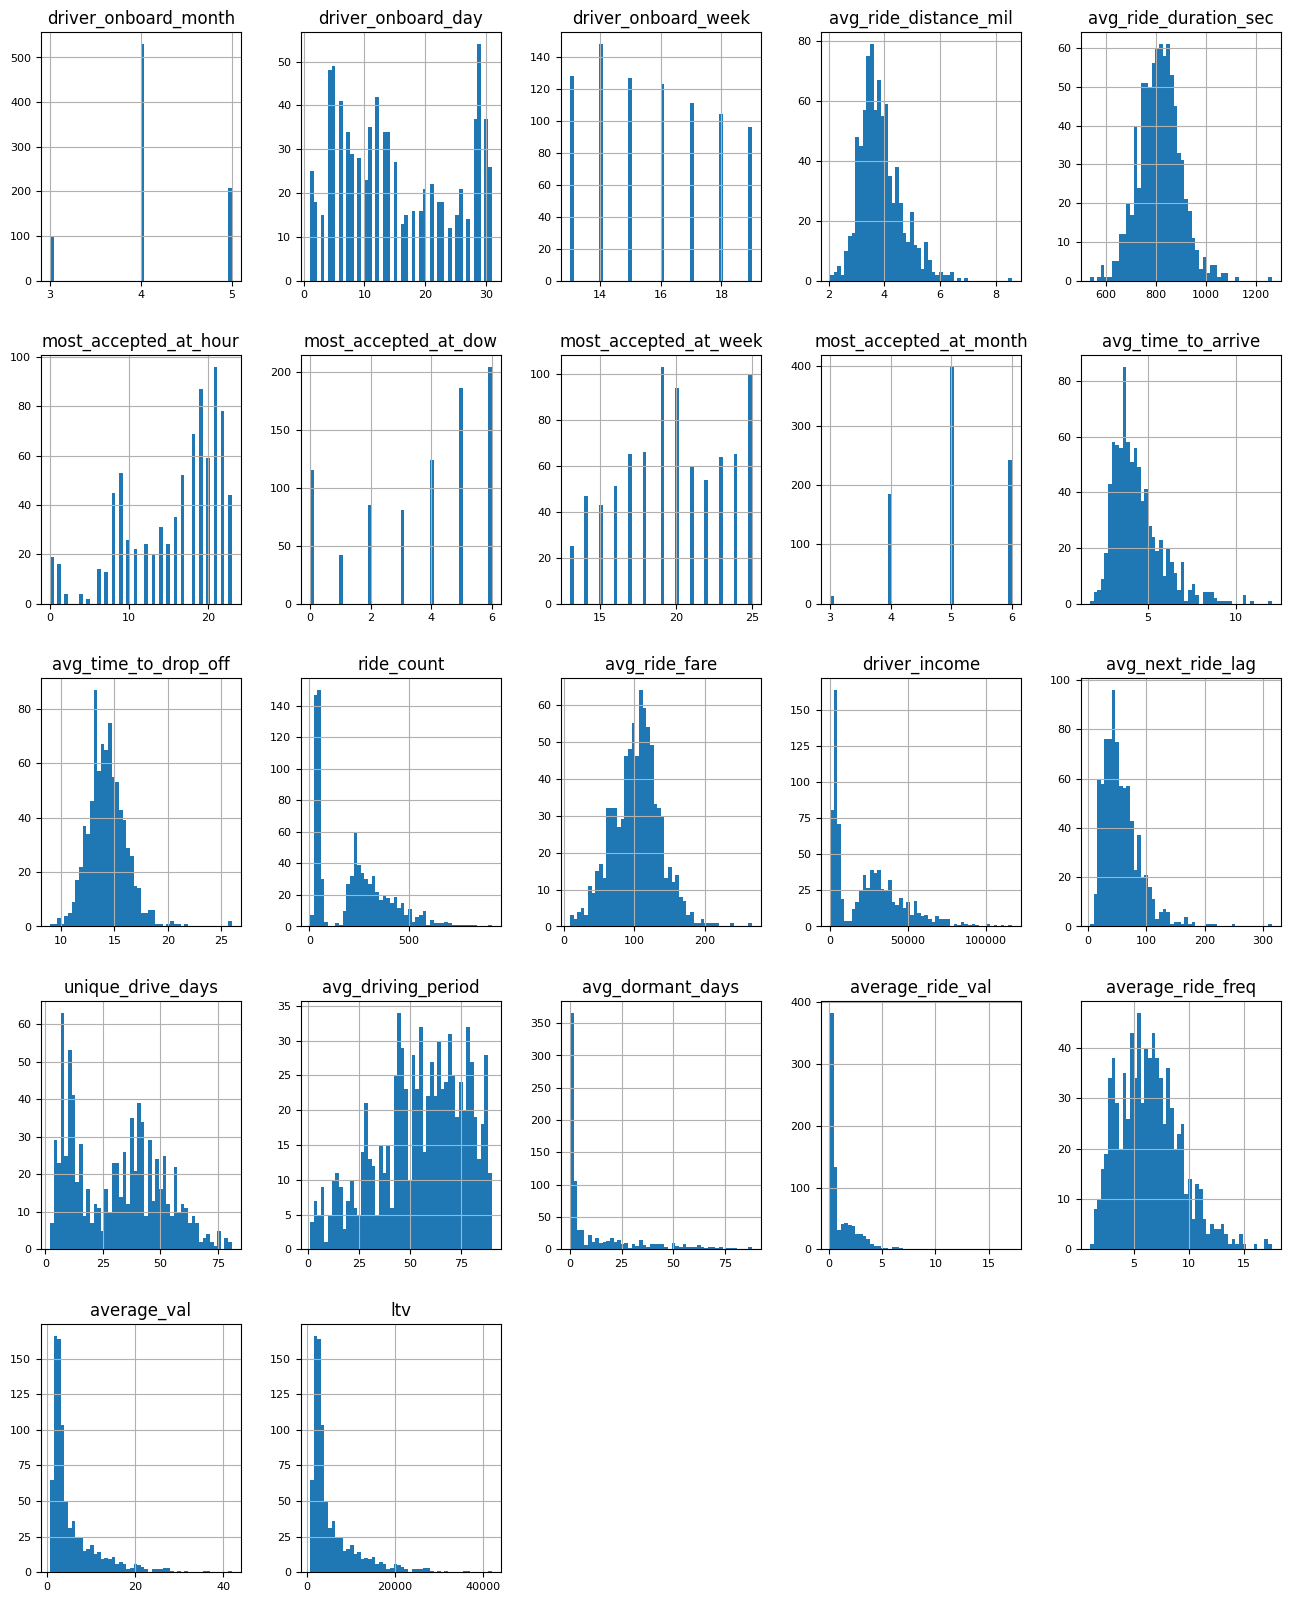

In [8]:
# Numerical Features
df_num = df_driver2.select_dtypes(include = ['float64', 'int64'])
df_num = df_driver2.drop(columns=['weekday_driver','evening_driver'])
_junk = df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

We can can see here that though most distributions are skewed, there are some normal distributions (yay), but we need to verify this with Q-Q plots later.

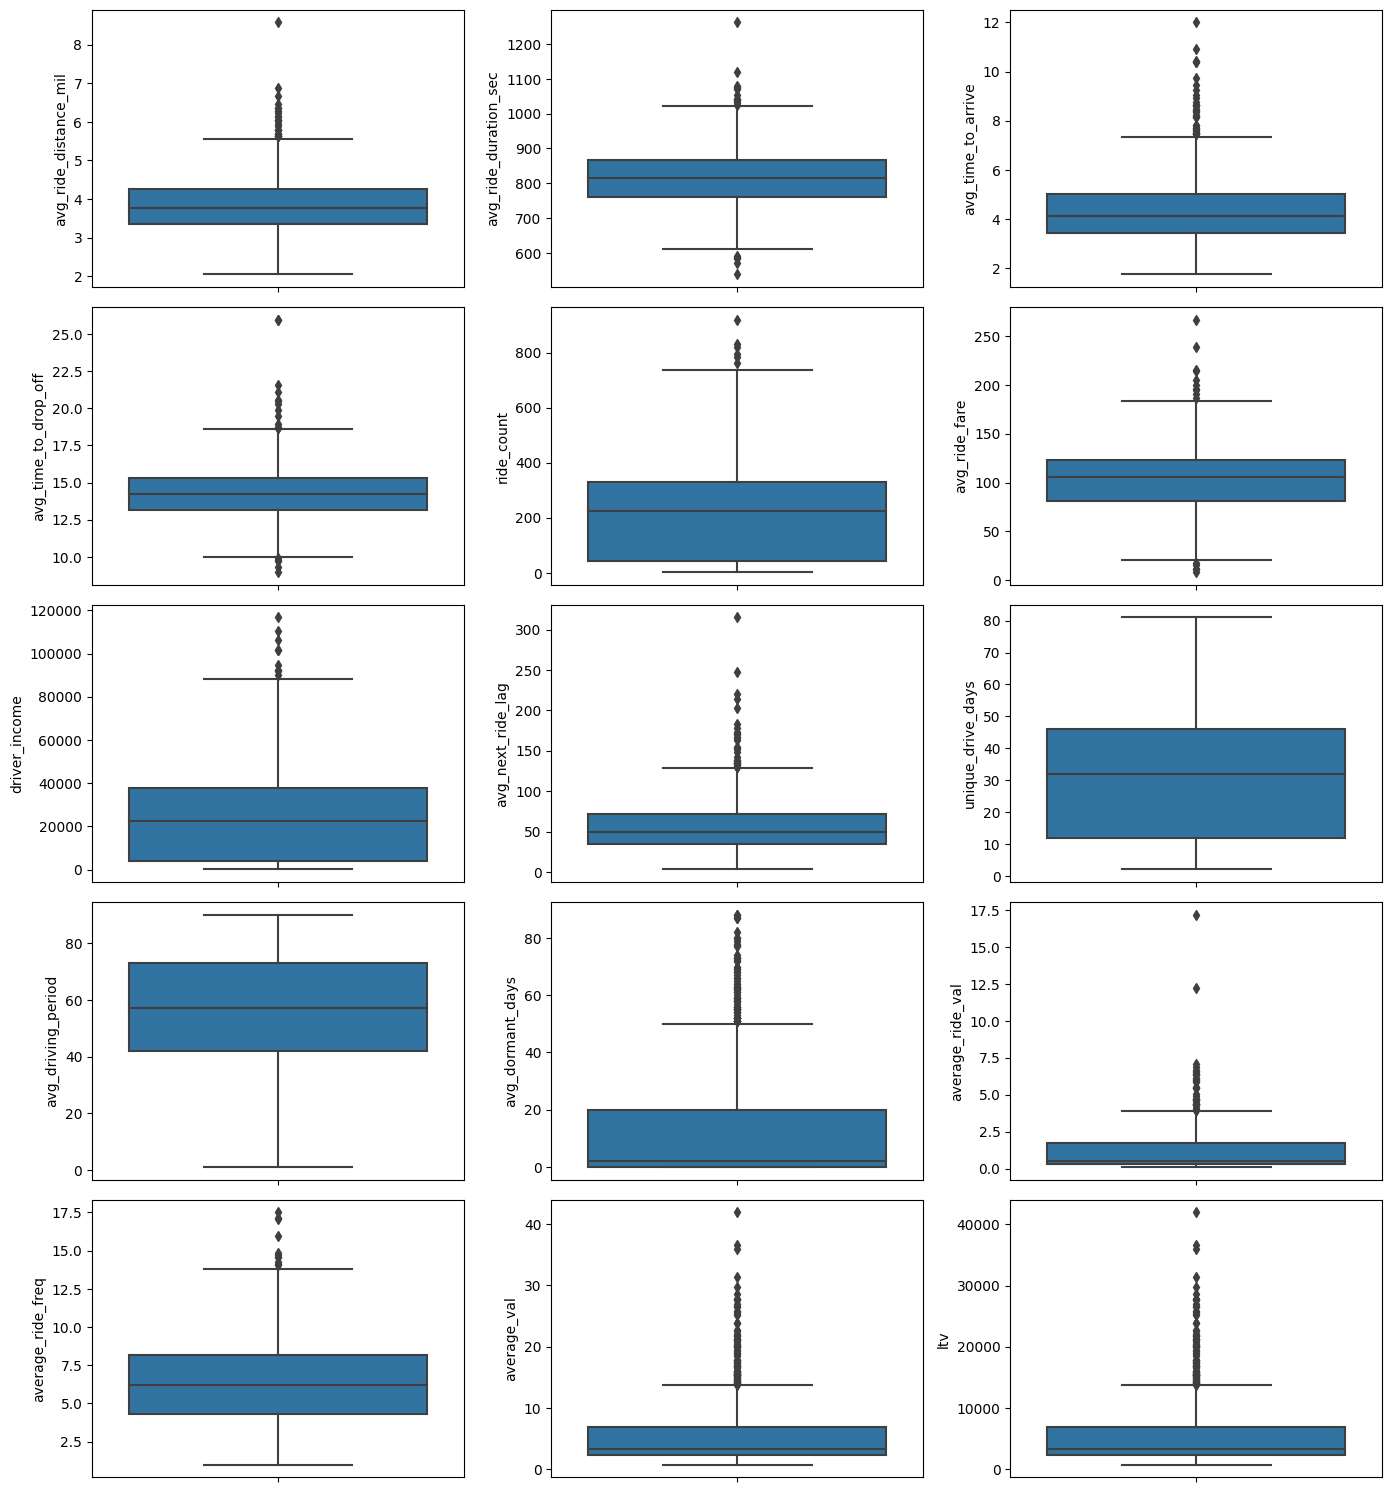

In [9]:
# Now let's take a look at the data and see the spread of our continuous numerical data.
# Create a figure for the boxplots
df_continuous = df_driver2[['avg_ride_distance_mil',
 'avg_ride_duration_sec',
 'avg_time_to_arrive',
 'avg_time_to_drop_off',
 'ride_count',
 'avg_ride_fare',
 'driver_income',
 'avg_next_ride_lag',
 'unique_drive_days',
 'avg_driving_period',
 'avg_dormant_days',
 'average_ride_val',
 'average_ride_freq',
 'average_val',
 'ltv']]
fig = plt.figure(figsize=(14,15))
for index,col in enumerate(df_continuous.columns):
    plt.subplot(5,3, index+1)
    sns.boxplot(y=col, data=df_continuous)
fig.tight_layout(pad=1.0)

We can see that some variables will need to have outliers taken care of using different strategies (log transform or mean/median/tail imputation)

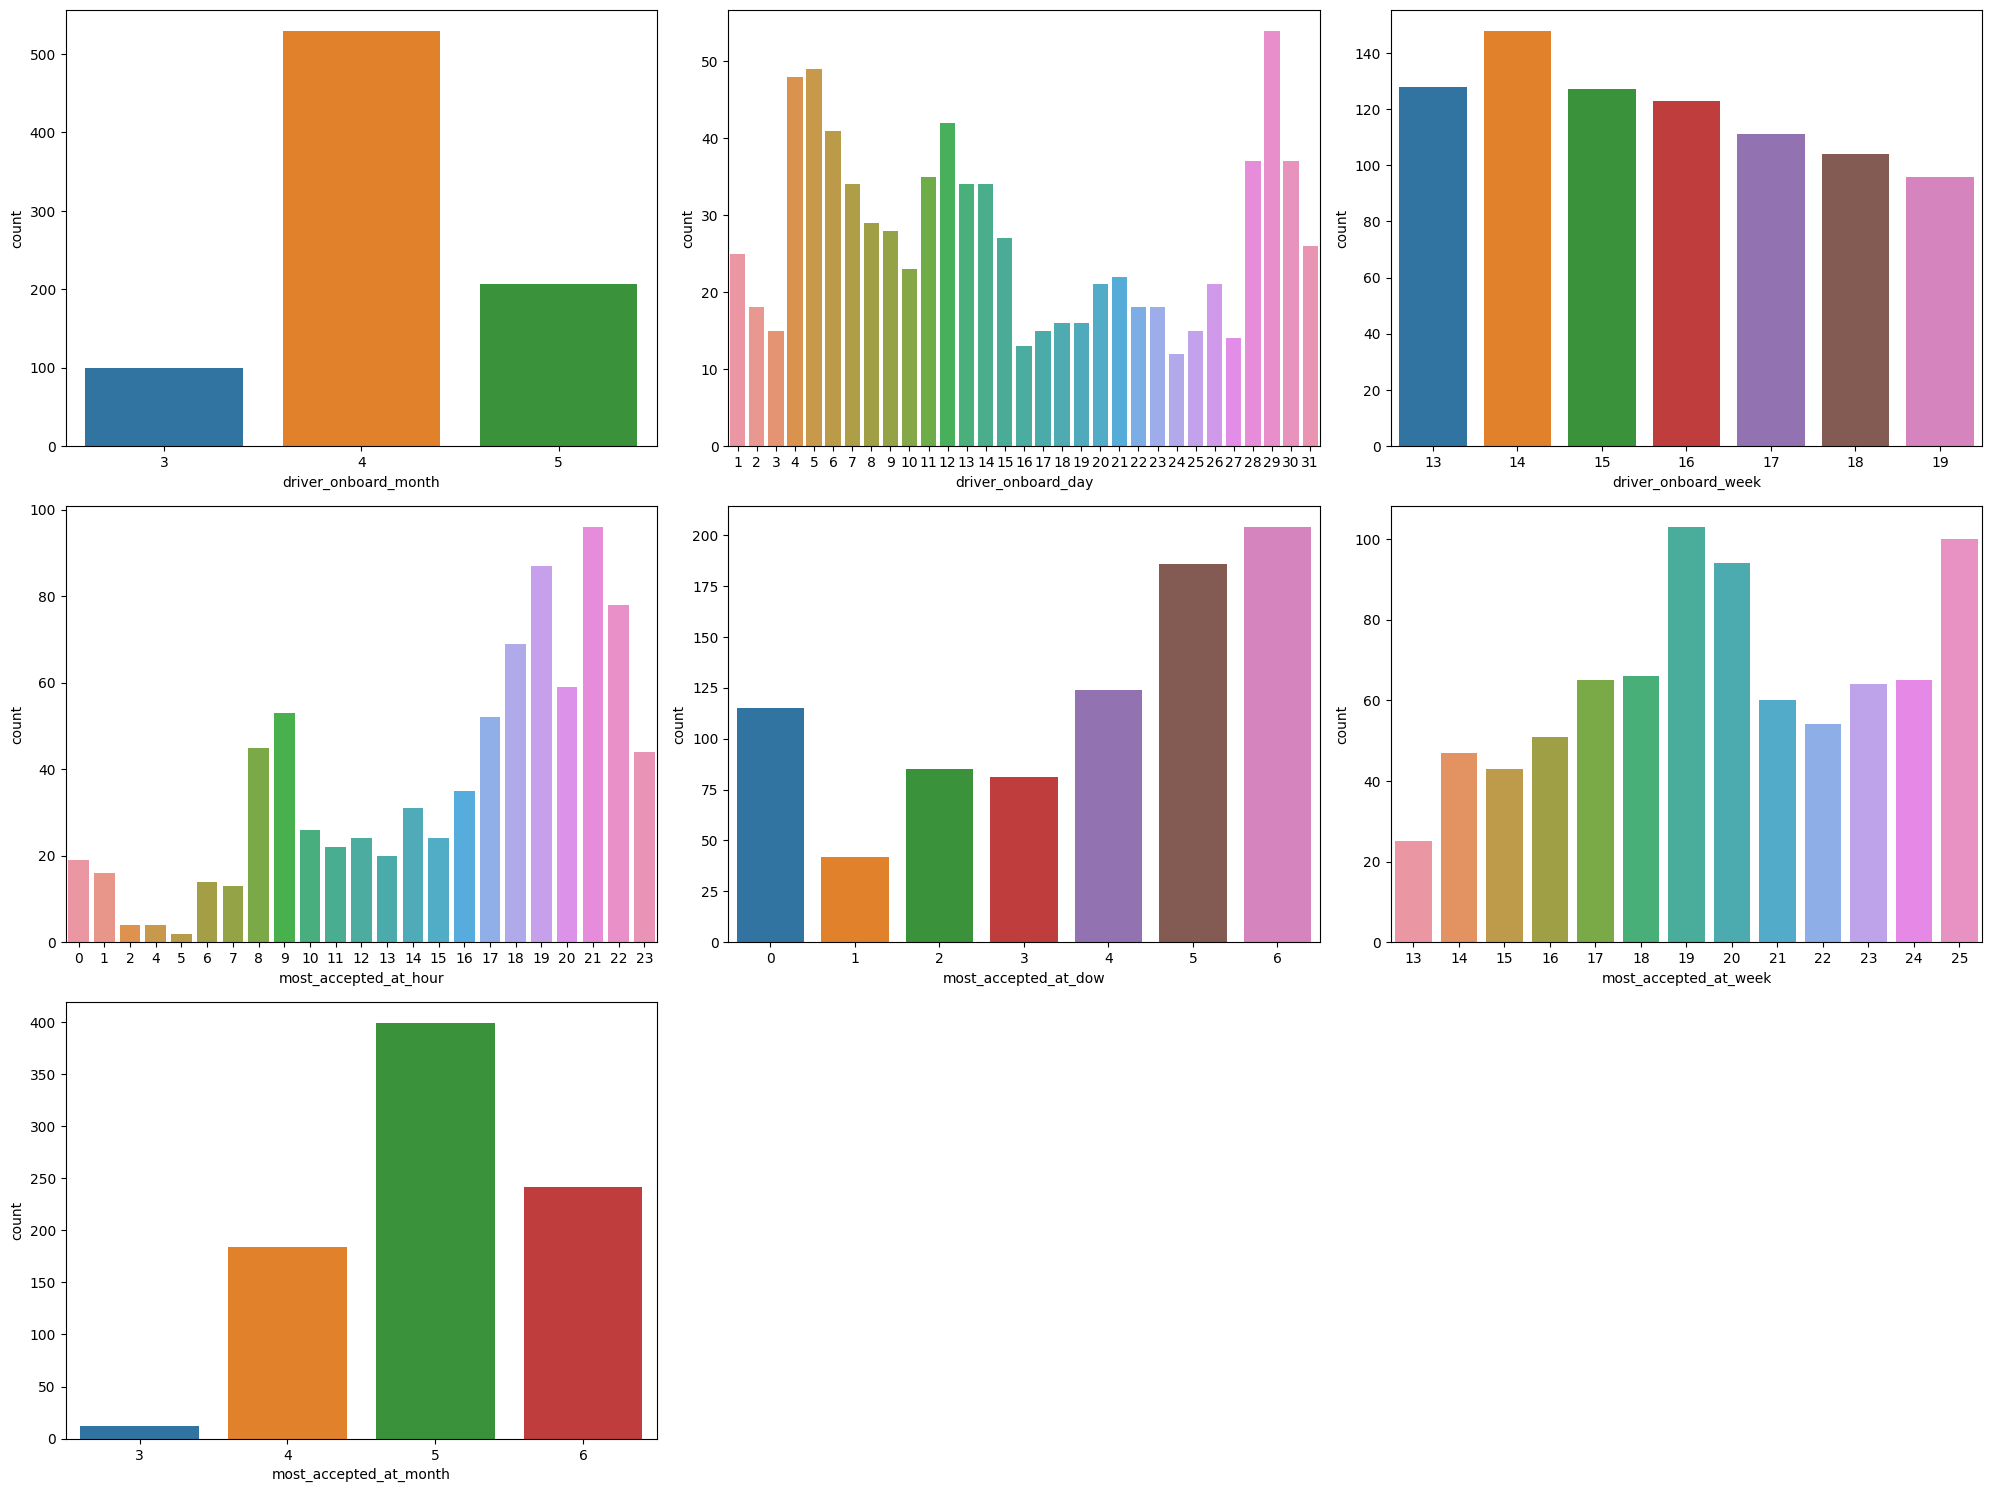

In [10]:
# Discrete values are:  
df_discrete = df_driver2[['driver_onboard_month',
 'driver_onboard_day',
 'driver_onboard_week',
 'most_accepted_at_hour',
 'most_accepted_at_dow',
 'most_accepted_at_week',
 'most_accepted_at_month',
]]
fig = plt.figure(figsize=(20,15))
for index,col in enumerate(df_discrete.columns):
    plt.subplot(3,3,index+1)
    sns.countplot(x=col, data=df_discrete)
fig.tight_layout(pad=1.0)

Most distributions are not uniform, mostly multi-modal. This is something to consider given that we are performing Linear Regression.

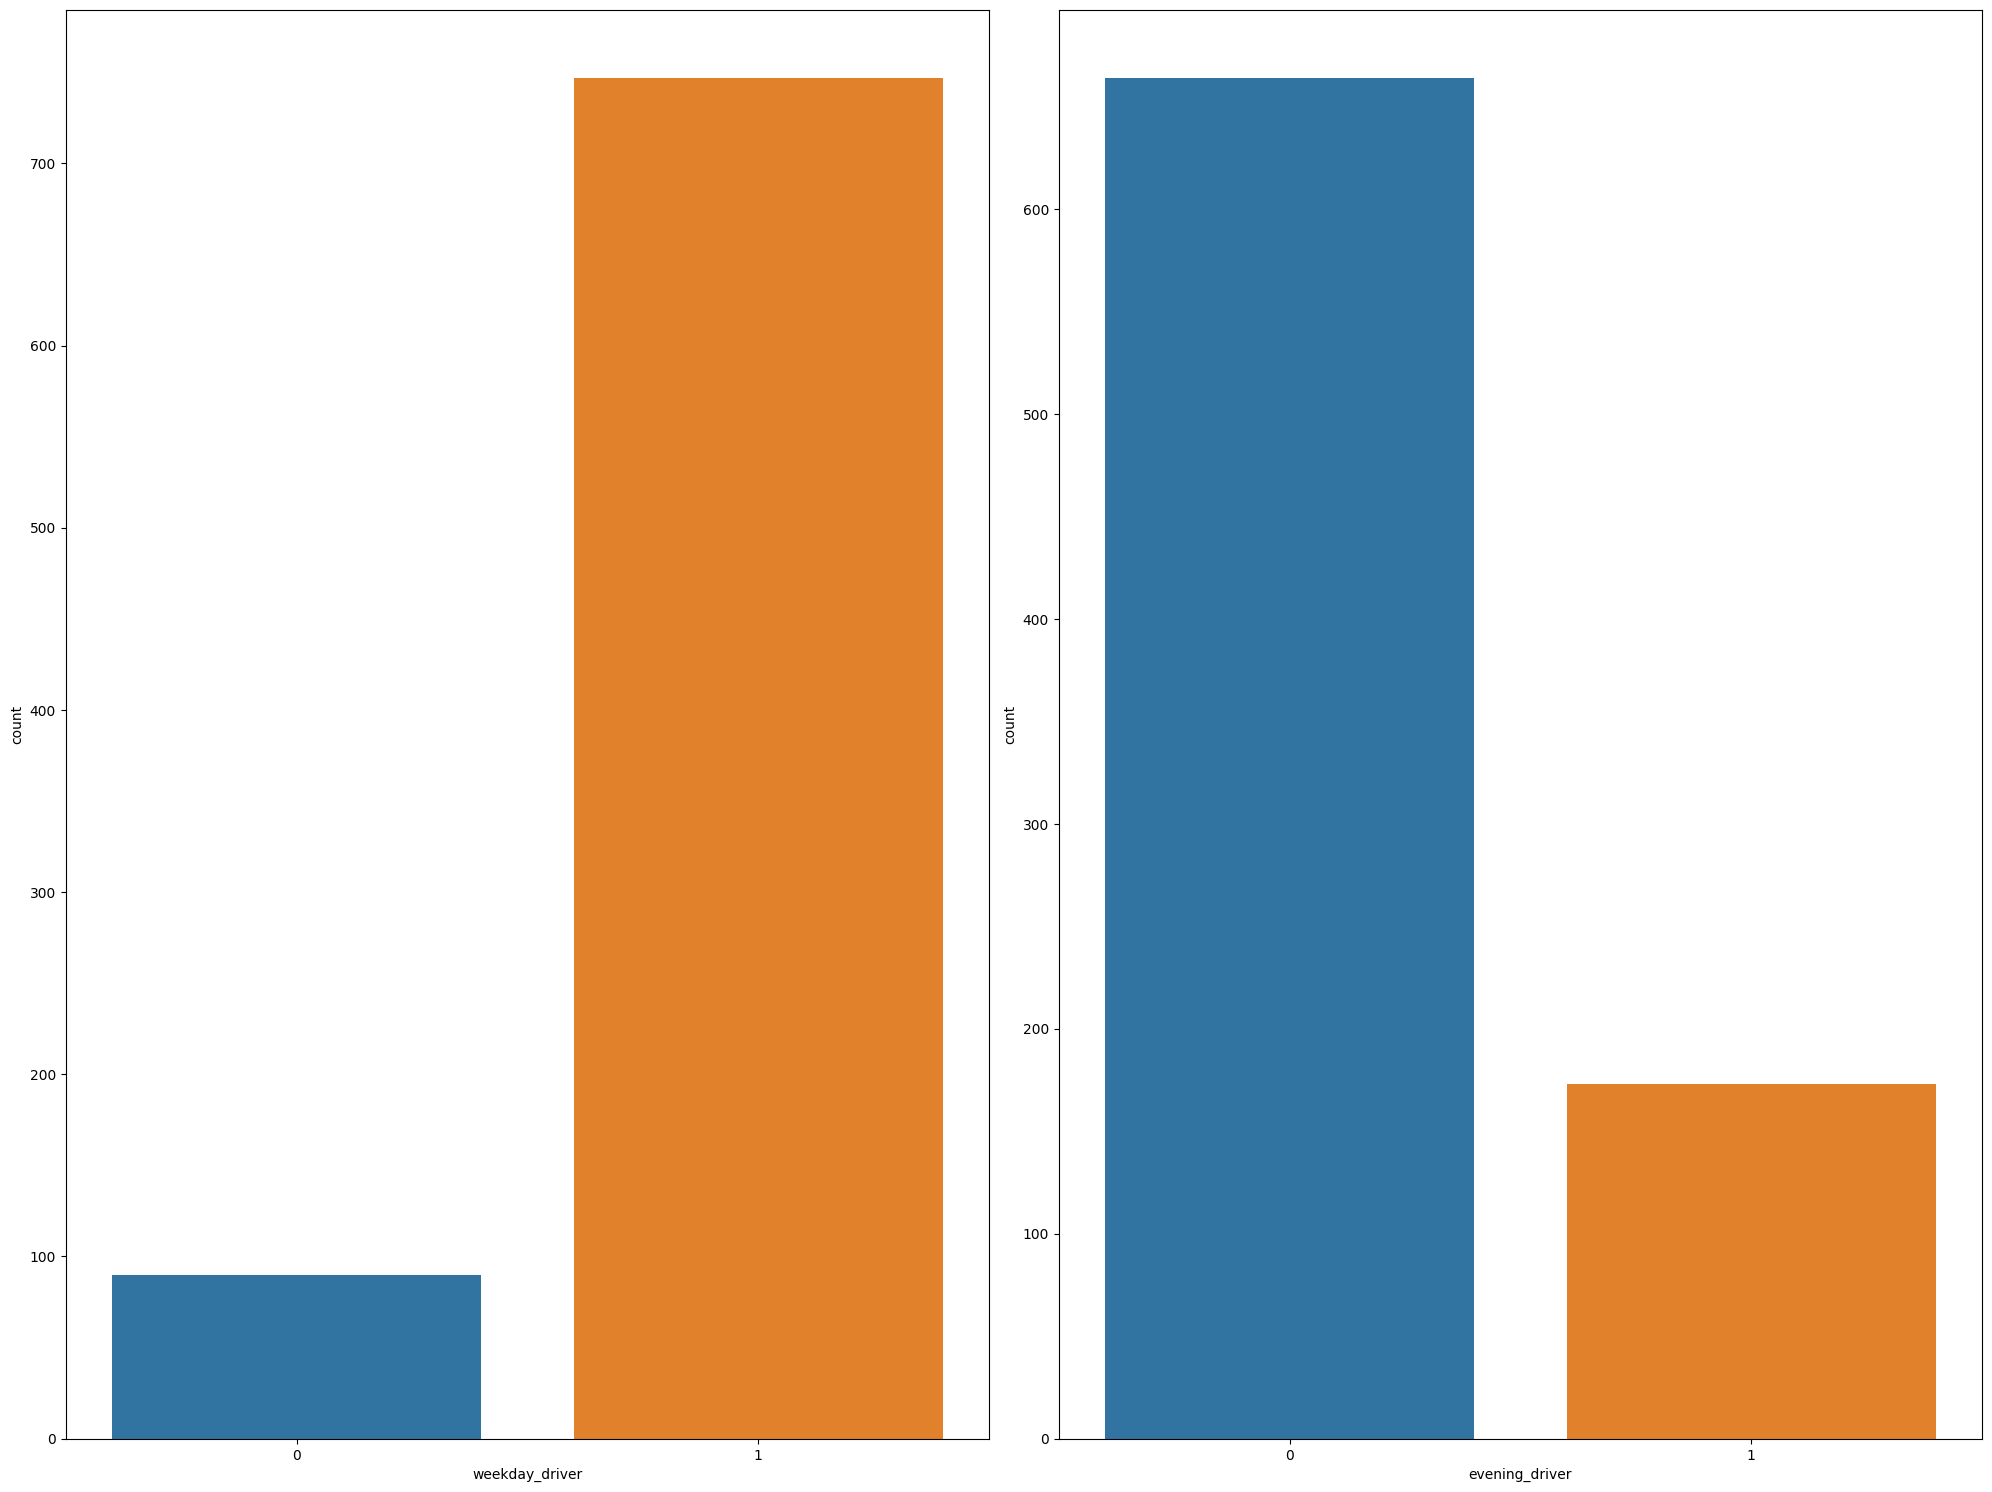

In [11]:
# Categorical are: weekday_driver, evening_driver
df_cat = df_driver2[['weekday_driver','evening_driver']]
fig = plt.figure(figsize=(20,15))
for index,col in enumerate(df_cat.columns):
    plt.subplot(1,2,index+1)
    sns.countplot(x=col, data=df_cat)
fig.tight_layout(pad=1.0)

We see here that most drivers drive on the weekdays and during the day. These are binary so do not need categorical transformation as usually is needed with categorical string values.

## Bivariate Analysis
This is to look at multi-collinearity. Another strategy would be: variance inflation factor (VIF).

<Axes: >

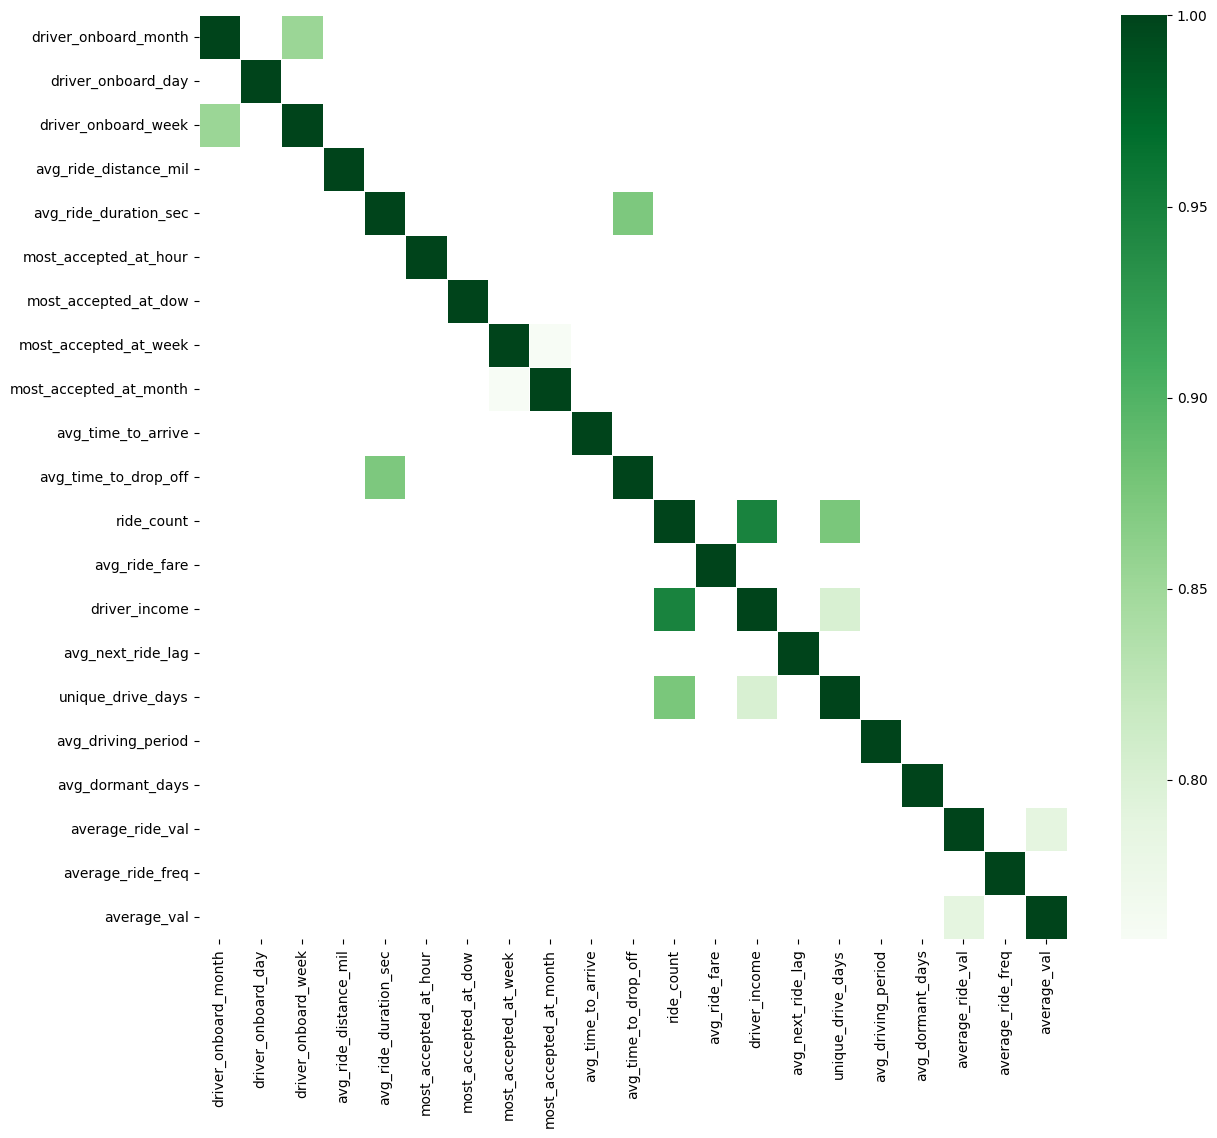

In [12]:
df_num2 = df_num.drop(columns=['ltv'])
plt.figure(figsize=(14,12))
correlation = df_num2.corr()
sns.heatmap(correlation, mask = correlation <0.75, linewidth=0.5, cmap='Greens')

We set a cut-off point of 0.75. So anything of interest would be equal to or greater than that value of correlation. 

Correlated values:
* pale green: lot of these are because they are derivates of an equation
    * driver_income and unique_drive_days
    * average_ride_val and average_val
* green: these are time-based similarities
    * driver_onboard_month and driver_onboard_week
    * avg_ride_duration_sec and avg_time_to_drop_off --these might just be the same calculation
    * ride_count and unique_drive_days
* dark green: besides on the diagonal
    * ride_count and driver_income

# Data Pre-Processing

## Removing redundant features
* including removing duplicate feature for total ride time and other redundant features

In [13]:
# variables demonstrating multi-collinearity
df_driver3 = df_driver2.drop(columns = ['driver_onboard_month', 'avg_time_to_drop_off'])

## Filling Missing Values

In [14]:
df_num2.isnull().sum()

driver_onboard_month      0
driver_onboard_day        0
driver_onboard_week       0
avg_ride_distance_mil     0
avg_ride_duration_sec     0
most_accepted_at_hour     0
most_accepted_at_dow      0
most_accepted_at_week     0
most_accepted_at_month    0
avg_time_to_arrive        0
avg_time_to_drop_off      0
ride_count                0
avg_ride_fare             0
driver_income             0
avg_next_ride_lag         1
unique_drive_days         0
avg_driving_period        0
avg_dormant_days          0
average_ride_val          0
average_ride_freq         0
average_val               0
dtype: int64

In [15]:
# Let us do a little back-tracking to see what caused this Null value

df_driver[df_driver['avg_next_ride_lag'].isnull()]

,driver_id,driver_onboard_month,driver_onboard_day,driver_onboard_week,avg_ride_distance_mil,avg_ride_duration_sec,most_accepted_at_hour,most_accepted_at_dow,most_accepted_at_week,most_accepted_at_month,...,evening_driver,avg_next_ride_lag,unique_drive_days,avg_driving_period,avg_dormant_days,churn,average_ride_val,average_ride_freq,average_val,ltv
574,7b625f643d0775f0ac4898e33235377b,4,4,14,2.049489,570.666667,18,2,16,4,...,0,NaN,3,15.0,68.0,1.0,2.854589,1.0,2.854589,2859.315869


In [16]:
## Get all rides from driver: 7b625f643d0775f0ac4898e33235377b	

df_driver[df_driver['driver_id'] == '7b625f643d0775f0ac4898e33235377b']

,driver_id,driver_onboard_month,driver_onboard_day,driver_onboard_week,avg_ride_distance_mil,avg_ride_duration_sec,most_accepted_at_hour,most_accepted_at_dow,most_accepted_at_week,most_accepted_at_month,...,evening_driver,avg_next_ride_lag,unique_drive_days,avg_driving_period,avg_dormant_days,churn,average_ride_val,average_ride_freq,average_val,ltv
574,7b625f643d0775f0ac4898e33235377b,4,4,14,2.049489,570.666667,18,2,16,4,...,0,NaN,3,15.0,68.0,1.0,2.854589,1.0,2.854589,2859.315869


In [17]:
# get ride level data from this driver: 7b625f643d0775f0ac4898e33235377b	
ride_level = pd.read_csv('/kaggle/input/lyft-analysis/df_feat.csv')
explore = ride_level[ride_level['driver_id'] == '7b625f643d0775f0ac4898e33235377b']
explore[['accepted_at_ts', 'dropped_off_at_ts','next_ride_lag']].sort_values(by='accepted_at_ts')

,accepted_at_ts,dropped_off_at_ts,next_ride_lag
163386,2016-04-04 16:36:17,2016-04-04 17:01:17,0.0
163385,2016-04-17 18:44:05,2016-04-17 18:47:13,0.0
163384,2016-04-19 18:49:49,2016-04-19 19:04:10,0.0


So the reason why next_ride_lag is NULL is because this particular driver had one ride for each of the 3 separate days s/he drove.

The business logic excluded back-to-back rides that spanned across two different days.

Let us take a look at next_ride_lag distribution again to determine what is the best strategy for imputation even though this is one driver amongst 837.

<Axes: >

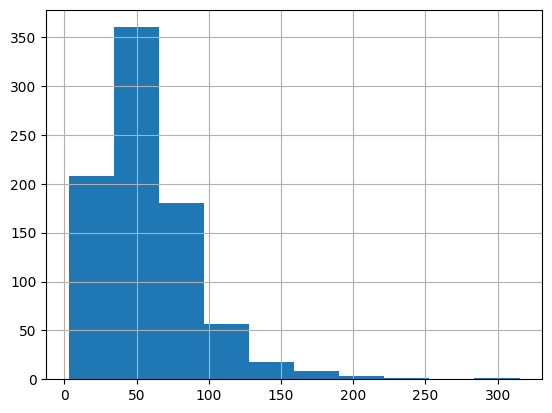

In [18]:
df_driver['avg_next_ride_lag'].hist()

In [19]:
# It is left skewed. So let us impute with the median, since median is better representative of centrality with outliers.
avg_next_ride_lag_median = df_driver3['avg_next_ride_lag'].median()

df_driver3['avg_next_ride_lag'].fillna(avg_next_ride_lag_median, inplace=True)
df_driver3.isnull().sum()

driver_onboard_day        0
driver_onboard_week       0
avg_ride_distance_mil     0
avg_ride_duration_sec     0
most_accepted_at_hour     0
most_accepted_at_dow      0
most_accepted_at_week     0
most_accepted_at_month    0
avg_time_to_arrive        0
ride_count                0
avg_ride_fare             0
driver_income             0
weekday_driver            0
evening_driver            0
avg_next_ride_lag         0
unique_drive_days         0
avg_driving_period        0
avg_dormant_days          0
average_ride_val          0
average_ride_freq         0
average_val               0
ltv                       0
dtype: int64

## Dealing with Outliers (starting with continous, then working with discrete)

1. Outliers: (e.g., data entry error, experimenter issue, out-of-range value); Perform screen of data points outside 2 SD
* why they need to be taken care of:
    * make algorithm not work properly
    * introduce noise to dataset
    * make samples less representative
2. What to do with them:
    * after defining what are outliers, examine if points make sense given business context
    * if decide to keep points, then transform or impute
        * For left skewed, long right tail distrubution then log tranform. Else use scikit-learn tranformation algorithm.
        * If not able to perform transformation, then impute with median.
    * if decide to not keep points, then remove
        * If outlier is small percentage and other columns have meat of their own data then discard row.

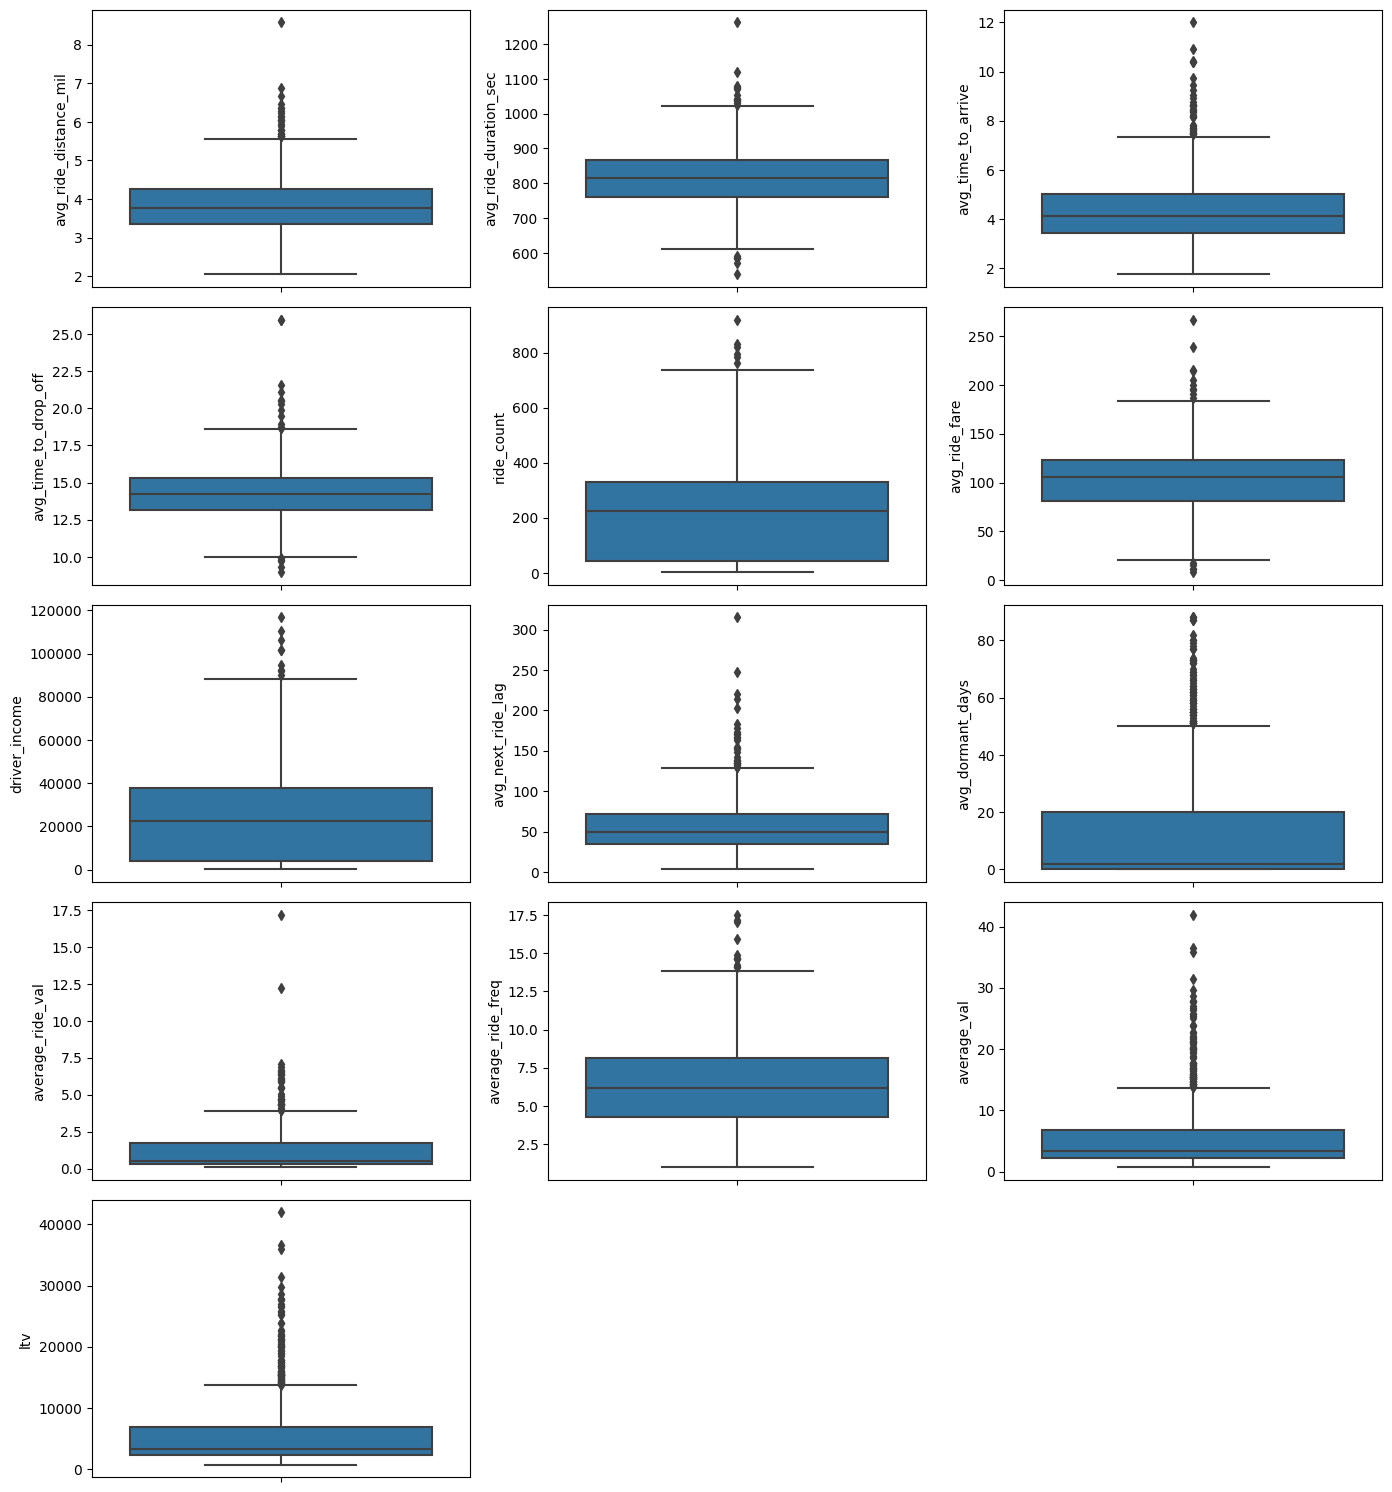

In [20]:
# examining if outliers make sense given business context
df_continuous2 = df_continuous.drop(columns=['unique_drive_days', 'avg_driving_period'])
fig = plt.figure(figsize=(14,15))
for index,col in enumerate(df_continuous2.columns):
    plt.subplot(5,3, index+1)
    sns.boxplot(y=col, data=df_continuous2)
fig.tight_layout(pad=1.0)

Bulk of the data and extremes make sense/as expected given rideshare problem.

In [21]:
# trying multiple ways to define outliers

# 2 SD might consider too much of the meat of the data as outlier, 
# but let us check before proceeding to another strategy: >75% of data

# Function to calculate the percentage of values outside 2 standard deviations
def percentage_outside_2std(test):
    result = {}
    for col in test.select_dtypes(include=[float, int]):  # Operate on numerical columns only
        mean = test[col].mean()
        std = test[col].std()
        lower_bound = mean - 2 * std
        upper_bound = mean + 2 * std
        
        # Count values outside the range
        outside_values = test[(test[col] < lower_bound) | (test[col] > upper_bound)]
        percentage_outside = (len(outside_values) / len(test[col])) * 100
        
        # Store result for the column
        result[col] = percentage_outside
    
    return result

# Get the percentage for each column
copy = df_continuous2.copy()
percentage_outside_2std(copy)

{'avg_ride_distance_mil': 5.4958183990442055,
 'avg_ride_duration_sec': 4.778972520908005,
 'avg_time_to_arrive': 4.659498207885305,
 'avg_time_to_drop_off': 4.659498207885305,
 'ride_count': 3.464755077658303,
 'avg_ride_fare': 4.540023894862605,
 'driver_income': 4.4205495818399045,
 'avg_next_ride_lag': 4.062126642771804,
 'avg_dormant_days': 7.287933094384708,
 'average_ride_val': 3.584229390681003,
 'average_ride_freq': 3.7037037037037033,
 'average_val': 5.4958183990442055,
 'ltv': 5.4958183990442055}

Small percentage given amount of variance expected per driver behavior.
Given this is an expected representation of the bulk of the data (< 10%), let us use 2SD definition to define our outliers. 
So we do not need to proceed with defining 75% of our data to detect outliers.

Ultimately determined outliers based on visual inspection, which means outliers were clearly out there from bulk of the data. Only one variable was imputed. The rest used alternative strategies to handle outliers.

<Axes: >

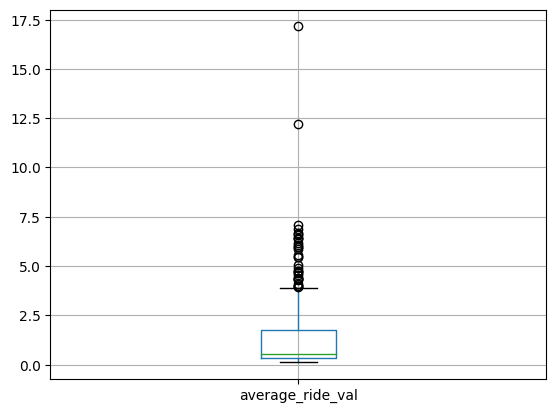

In [22]:
# After visually inspecting box plots and thinking about possible outliers in the dataset, 
# we ended up imputing one variable and not removing any features.

df_continuous2.boxplot(column='average_ride_val')

<Axes: >

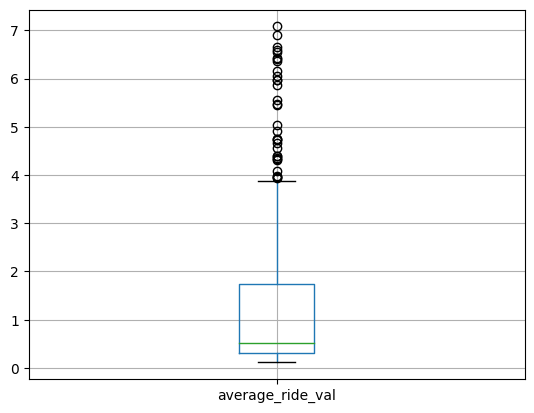

In [23]:
# Imputing with Mean versus Median since there are minimal amount of outliers.

impute_mean = df_continuous2[df_continuous2['average_ride_val'] <= 10]['average_ride_val'].mean()
# Replace Outliers with Mean
df_driver3['average_ride_val'] = df_driver3['average_ride_val'].apply(lambda x: impute_mean if x > 10 else x)
df_driver3.boxplot(column='average_ride_val')

In [24]:
# Moving on from continuous, to looking at discrete and categorical variables, do we see any outliers (categories with low representation)?

# Only columns of concern are: 'most_accepted_at_month','weekday_driver','evening_driver'
# Most accepted at month has low numbers because the window of time starts at the end of March
# Weekday and Evening drivers have class imbalance due to heavy representation of weekday and day drivers.
len(df_driver3[df_driver3['most_accepted_at_month']==3])/len(df_driver3)

0.014336917562724014

In order to mitigate issues with discrete variable outliers and class imbalance, will explore algorithms like ensemble methods (Random Forests, Gradient Boosting, and XGBoost) that handle extreme values better.

First, we will attempt Linear Regression, which requires further feature manipulations.

# For Linear Regression/Non-Tree Algorithms (Transformation, Scaling)

Transformation is necessary to makes assumptions for Linear Regression are met between features and target variables.

Scaling is not necessary for the model to predict, but to optimize it. Optimization techniques include Gradient Descent and Regularizartion (Ridge and Lasso). Another necessity for scaling would be for coefficient intpretation, which will not be covered in depth here.
___
# Feature Transformation (Normalization)
Needed since we are assuming linear relationship between X and Y.

* Different Options for Skewed Features:
    * Log Transform for Left Skewed (long right tail) 
    * Box-Cox/Quantile for LogNormal 
    * Box-Cox/Yeo-Johnson/Quantile for Chi-Squared
    * Box-Cox/Yeo-Johnson/Quantile for Weibull
    * Quantile for Uniform 
    * Quantile for Multimodal

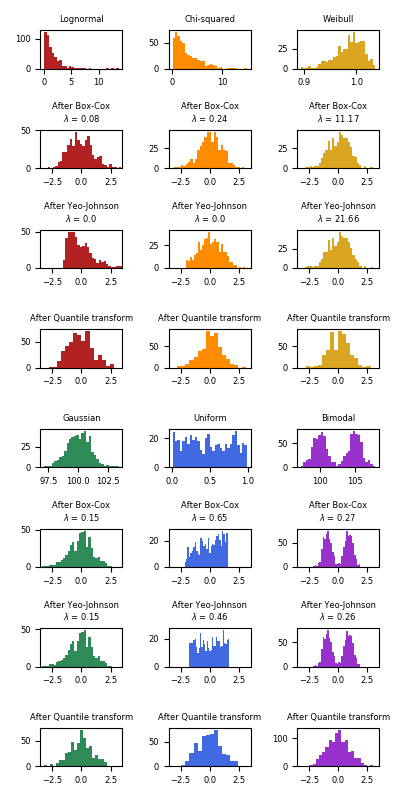

## Determining Features that are Non-Normal and Therefore Need Transformation
Using Q-Q plot to see which distributions are closest to Normal aka Gaussian

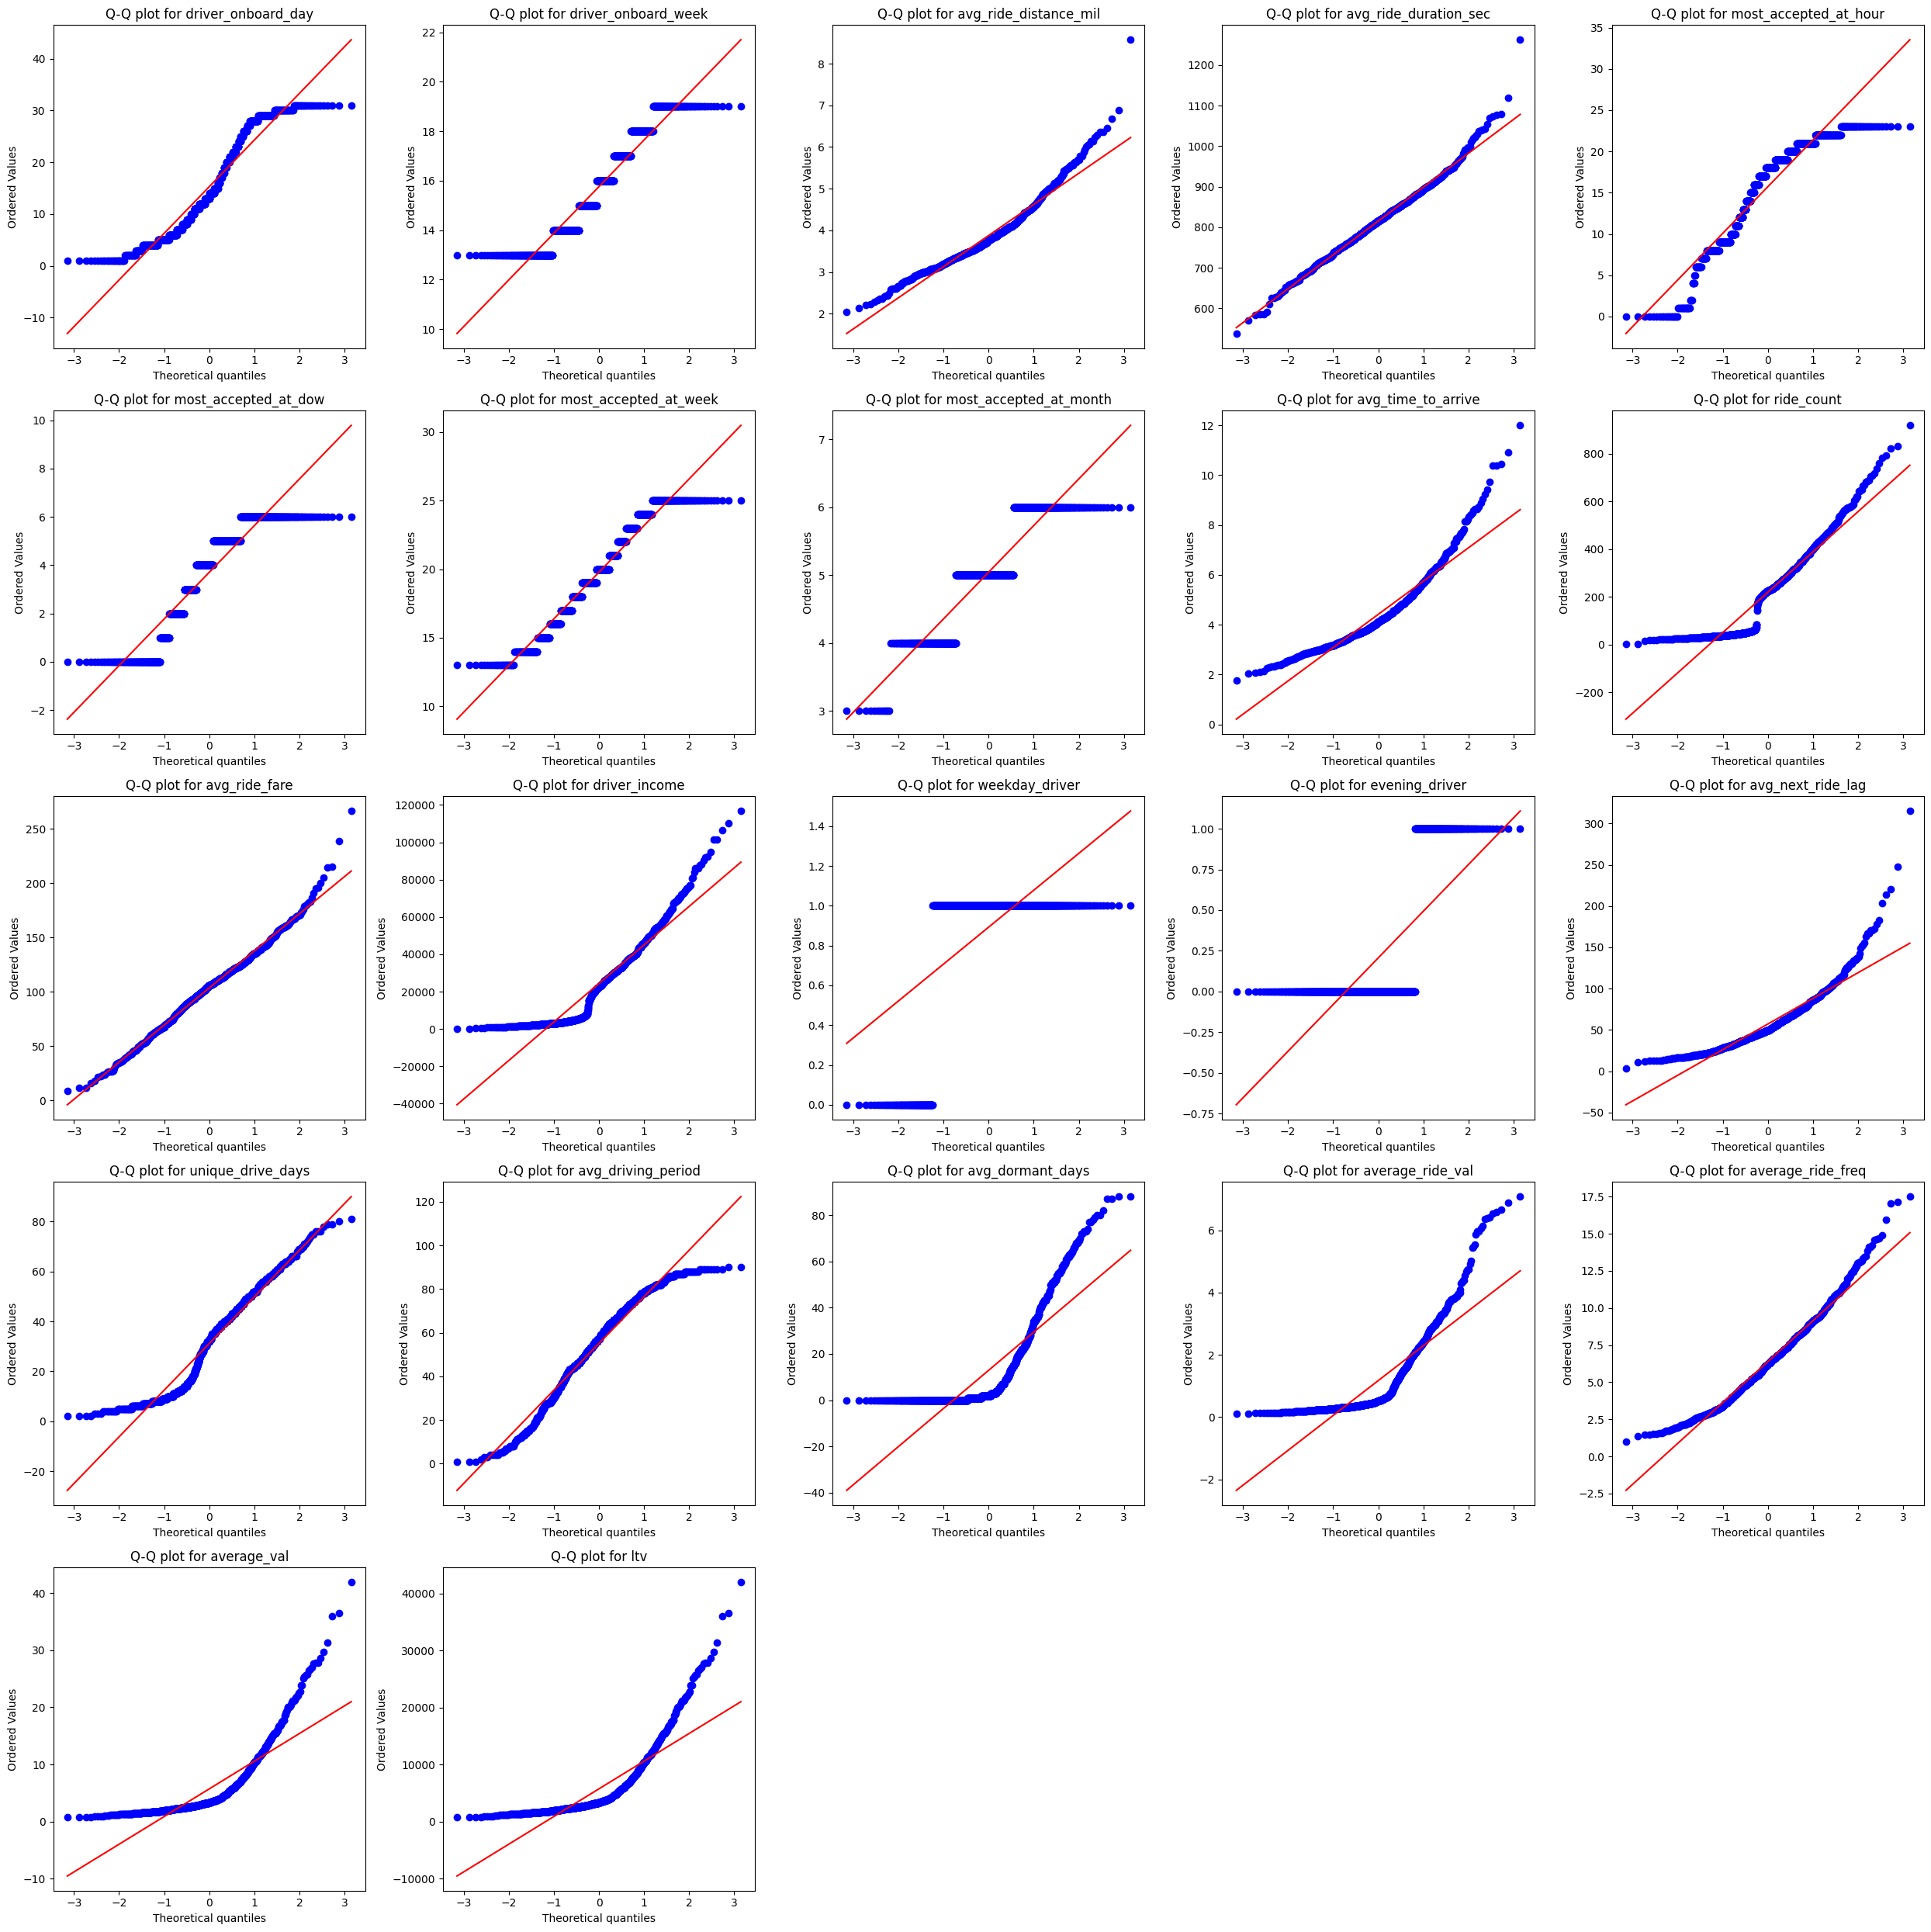

In [25]:
# Determine the number of rows and columns for the subplot grid
num_cols = len(df_driver3.columns)
plots_per_row = 5
num_rows = (num_cols + plots_per_row - 1) // plots_per_row

# Create a figure and axes
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(plots_per_row*5, num_rows*5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot a Q-Q plot for each column
for i, column in enumerate(df_driver3.columns):
    stats.probplot(df_driver3[column], dist="norm", plot=axes[i])
    axes[i].set_title(f'Q-Q plot for {column}')

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [26]:
# total feature distributions: 22
# Below distributions are grouped into their closest distribution type

# Gaussian - as reference; not necessarily needing transformation
gaussian = ['avg_ride_distance_mil', 'avg_ride_duration_sec', 'avg_ride_fare']

# Left Skewed
left = ['avg_time_to_arrive', 'avg_next_ride_lag', 'avg_dormant_days', 'average_ride_val', 'average_val', 'average_ride_freq', 'ltv', 'ride_count', 'driver_income']

# Weibull
weibull = ['avg_driving_period']

# Multimodal
modal = ['driver_onboard_day', 'driver_onboard_week', 'most_accepted_at_hour', 'most_accepted_at_dow', 'most_accepted_at_week', 'most_accepted_at_month', 'unique_drive_days', 'weekday_driver', 'evening_driver']

#### Testing if transformations actually make features look more normal.

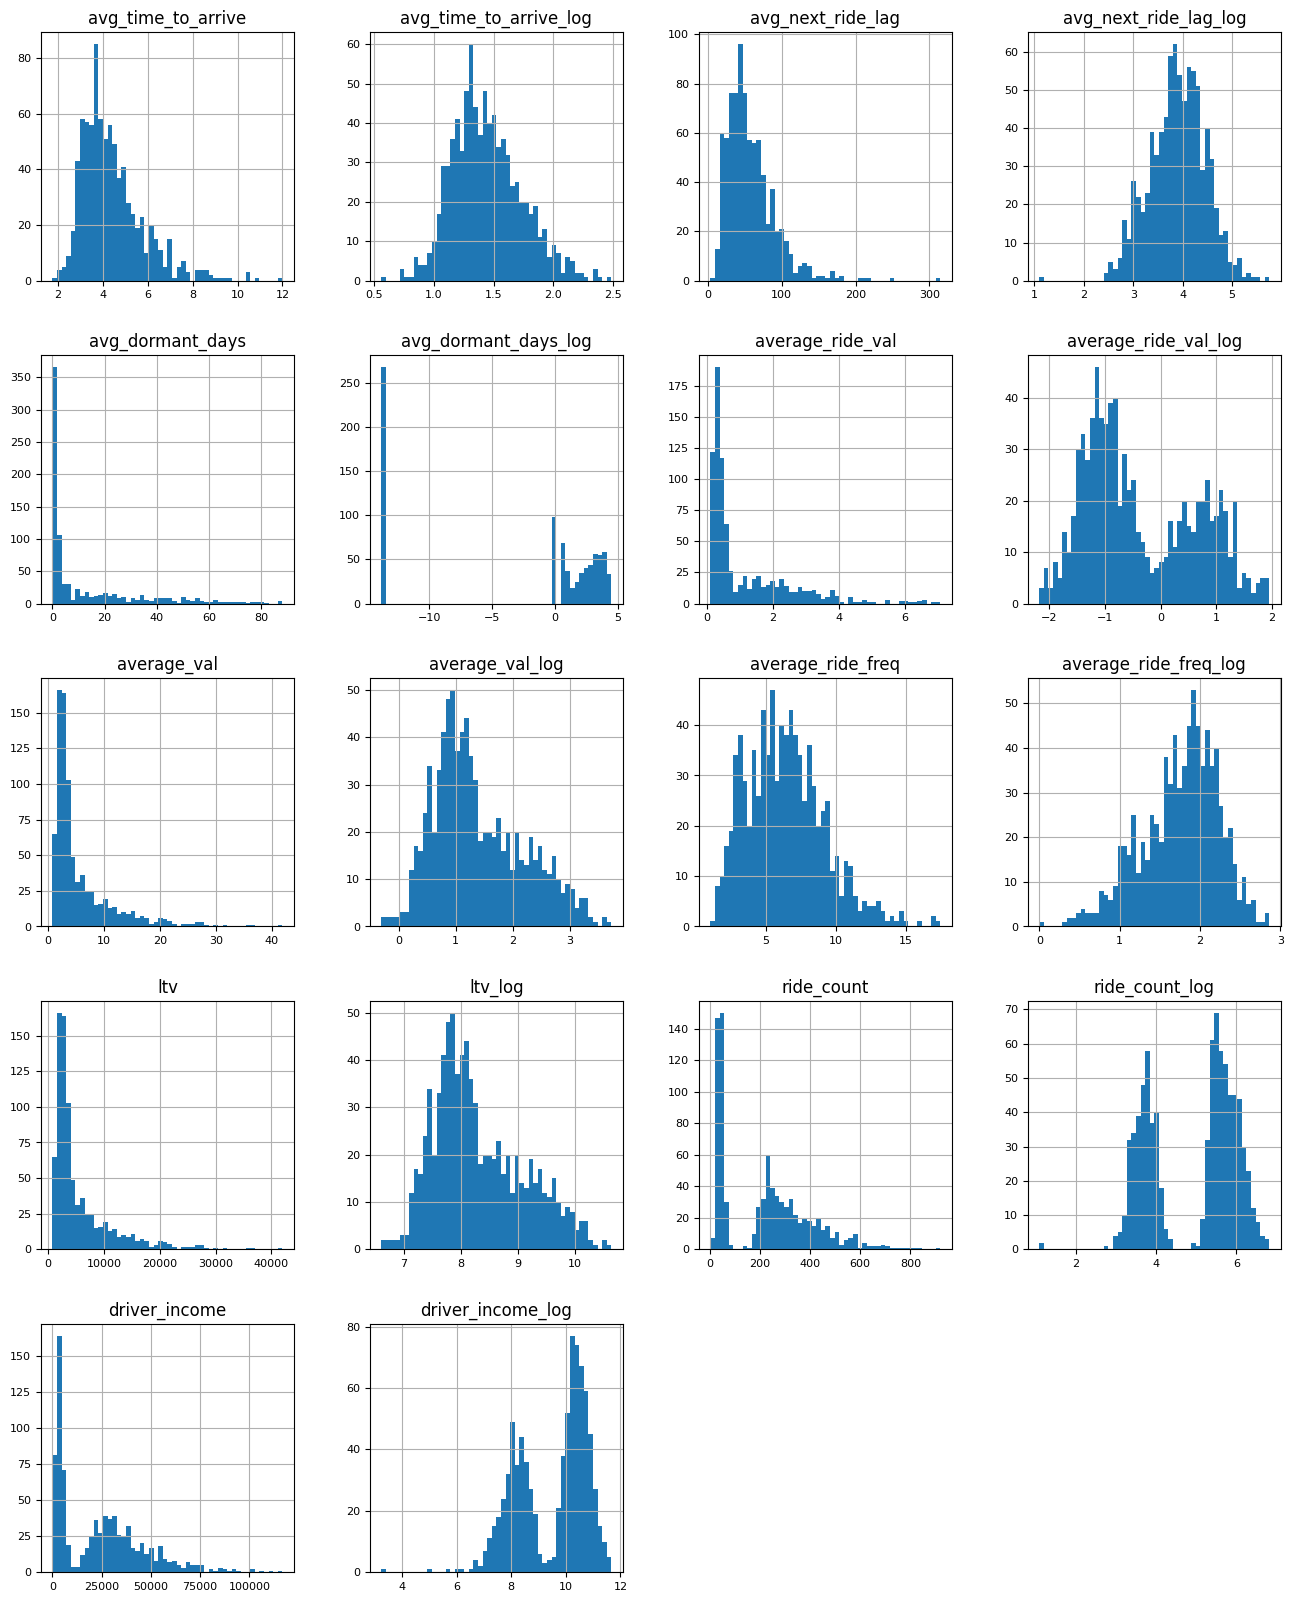

In [27]:
# Log Transform Left Skewed Distributions

testing = df_driver3.copy()

for col in left:
    testing[f'{col}_log'] = np.log(testing[col] + 1e-6)  # Adding a small constant to handle zeros
    
log_trans = testing[['avg_time_to_arrive', 'avg_time_to_arrive_log','avg_next_ride_lag', 'avg_next_ride_lag_log','avg_dormant_days', 'avg_dormant_days_log', 'average_ride_val','average_ride_val_log',  'average_val','average_val_log', 'average_ride_freq','average_ride_freq_log',  'ltv', 'ltv_log', 'ride_count','ride_count_log',  'driver_income', 'driver_income_log']]

_junk = log_trans.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

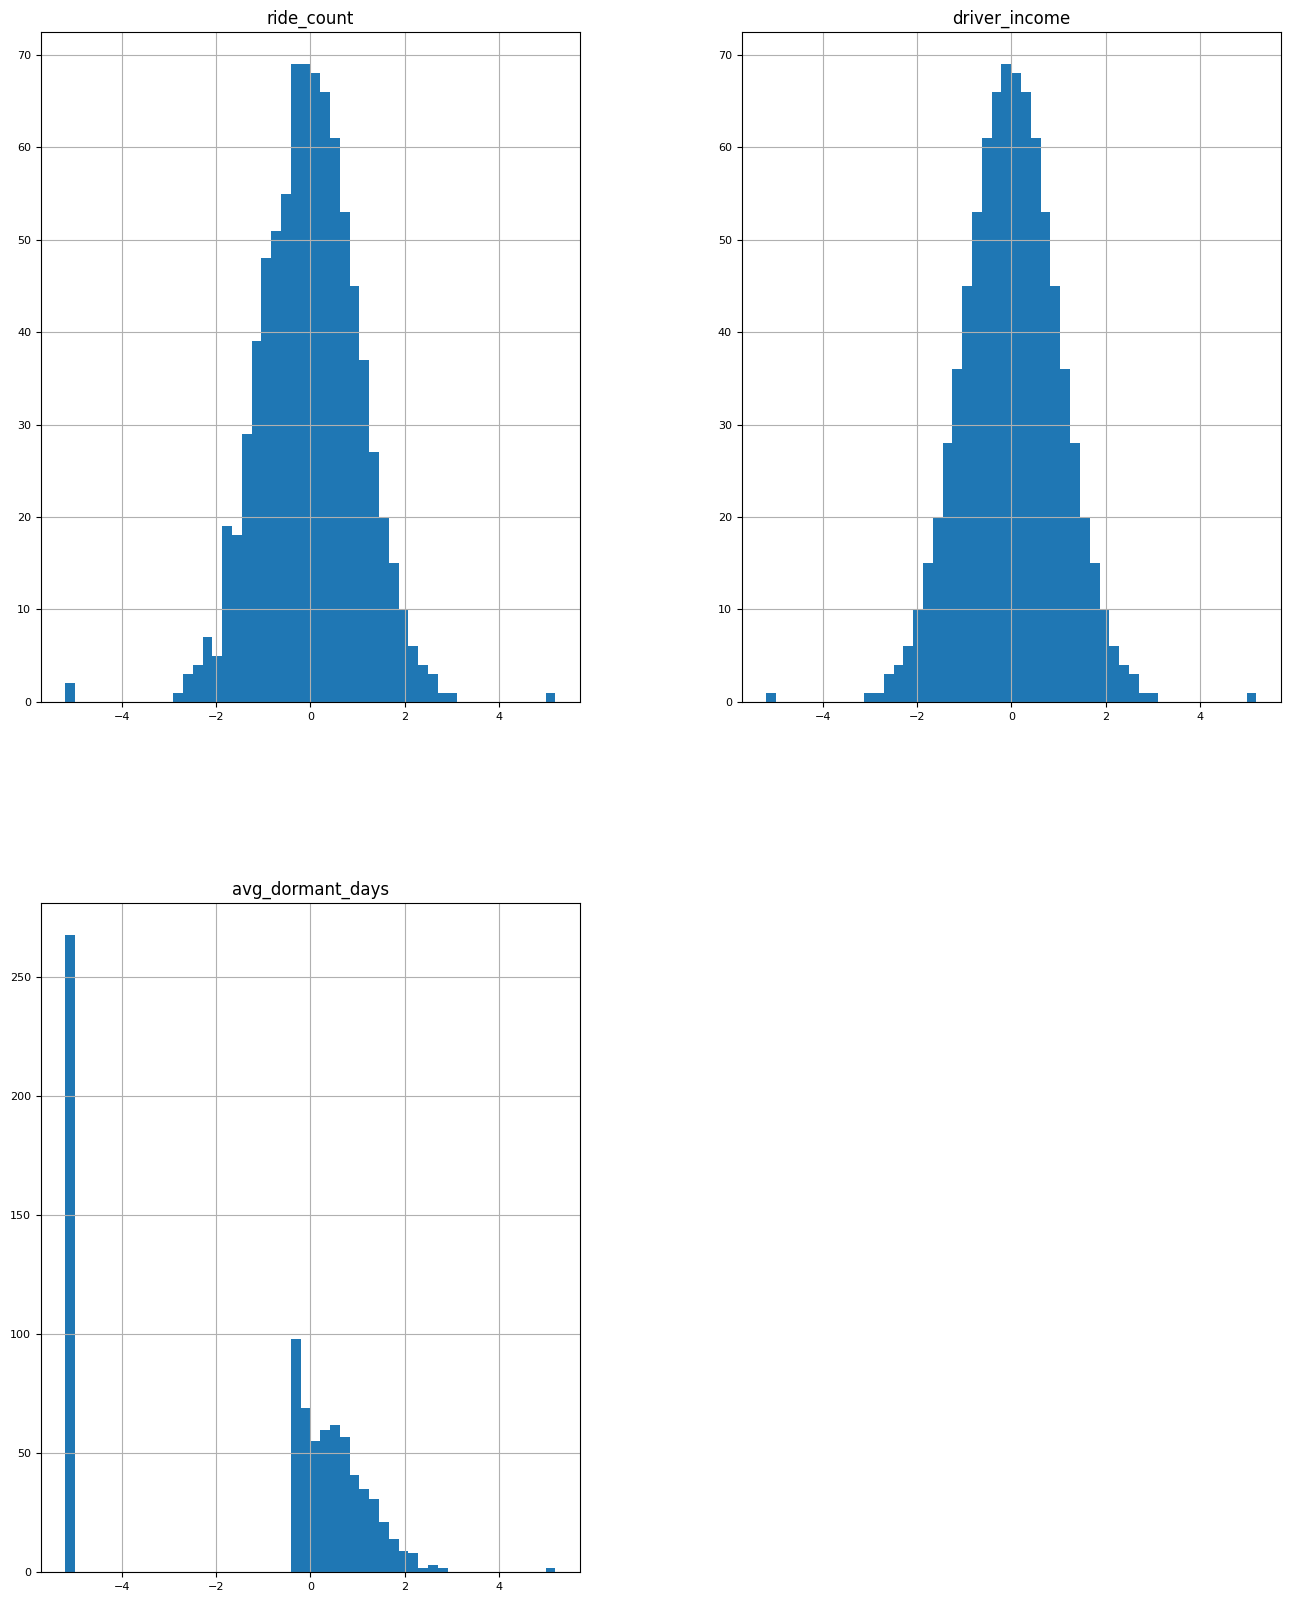

In [28]:
# Trying quantile transformation on left-skewed data that did not work with log transformation

alt_to_log = ['ride_count', 'driver_income', 'avg_dormant_days']

testing = df_driver3.copy()

qt = QuantileTransformer(output_distribution='normal') # 'uniform' or 'normal'

# Fit and transform the selected columns
testing[alt_to_log] = qt.fit_transform(testing[alt_to_log])

compare_alt_to_log = testing[alt_to_log]

_junk = compare_alt_to_log.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

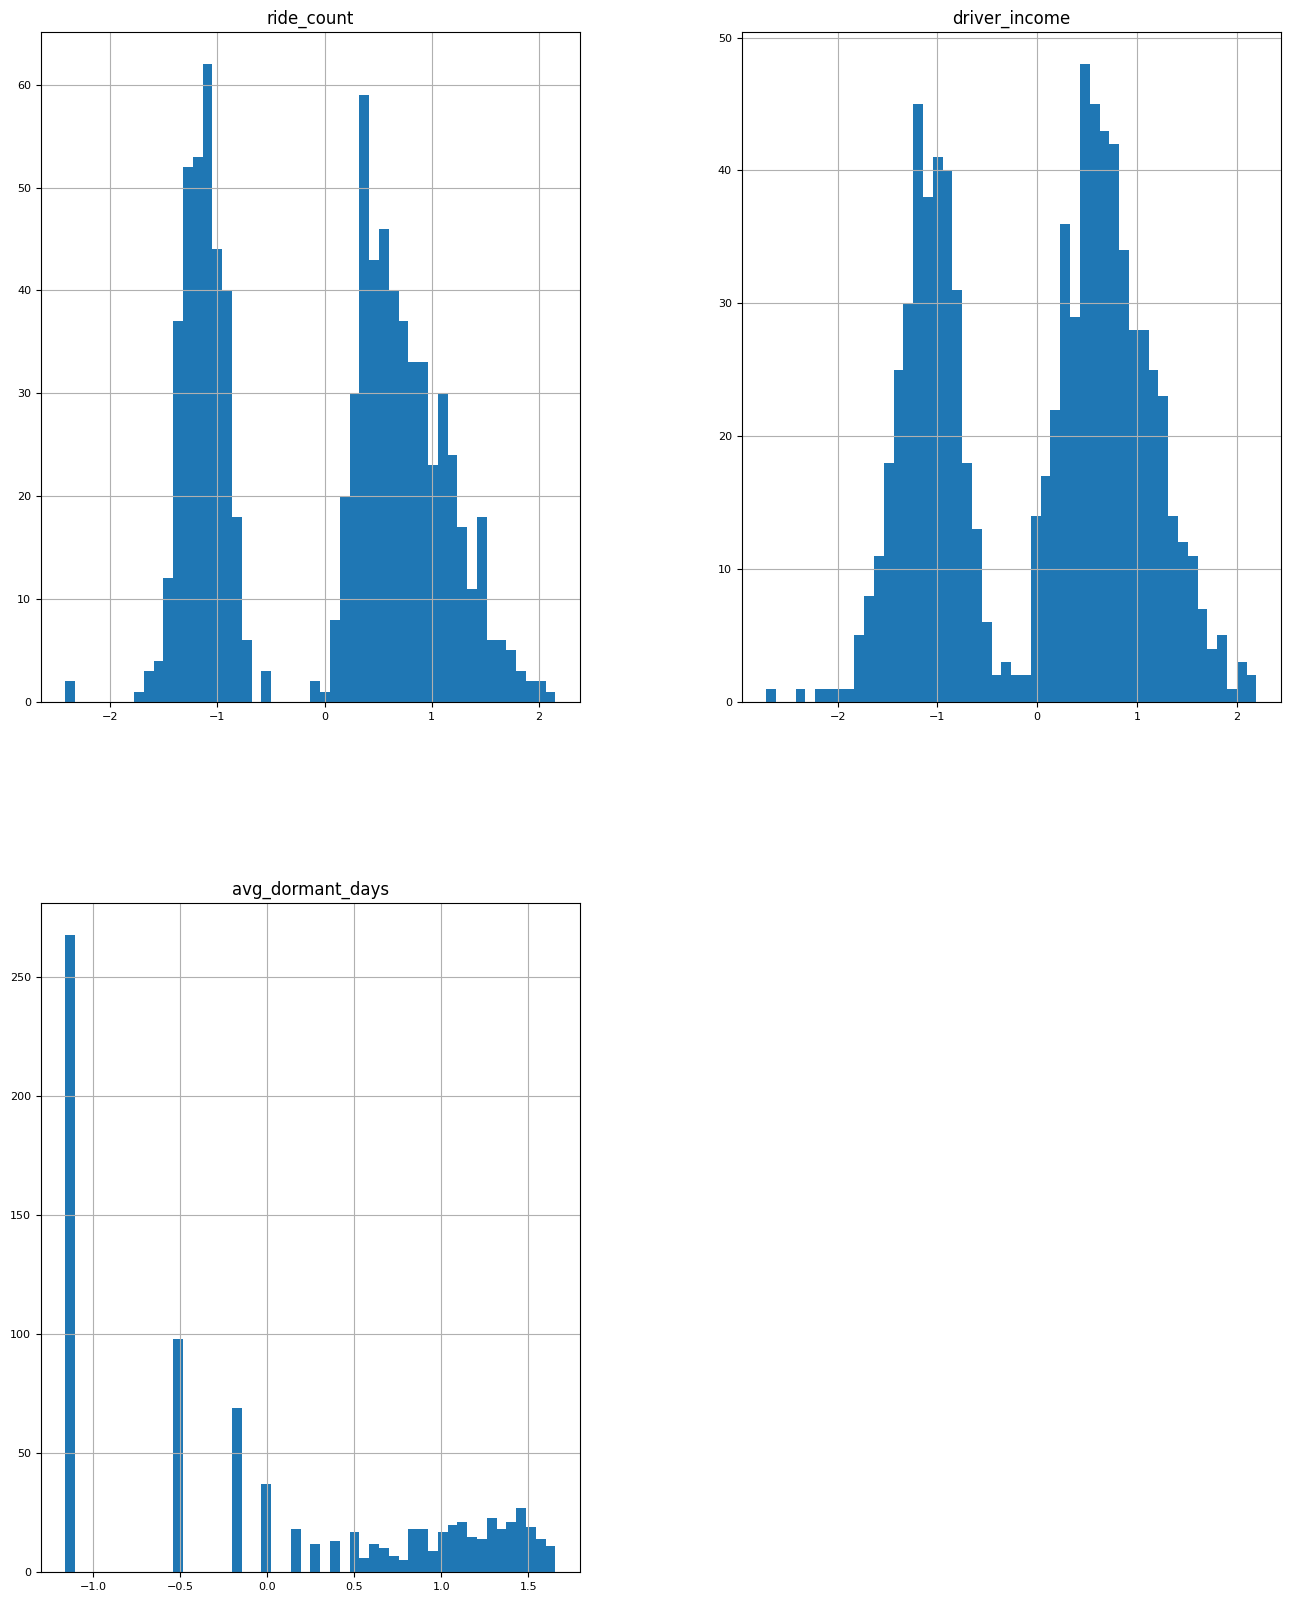

In [29]:
# Trying yeo-johnson transformation on left-skewed that did not work with log transformation

testing = df_driver3.copy()

# Initialize the PowerTransformer for Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson')

# Fit and transform the selected columns
testing[alt_to_log] = pt.fit_transform(testing[alt_to_log])

yj_alt_to_log = testing[alt_to_log]

_junk = yj_alt_to_log.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

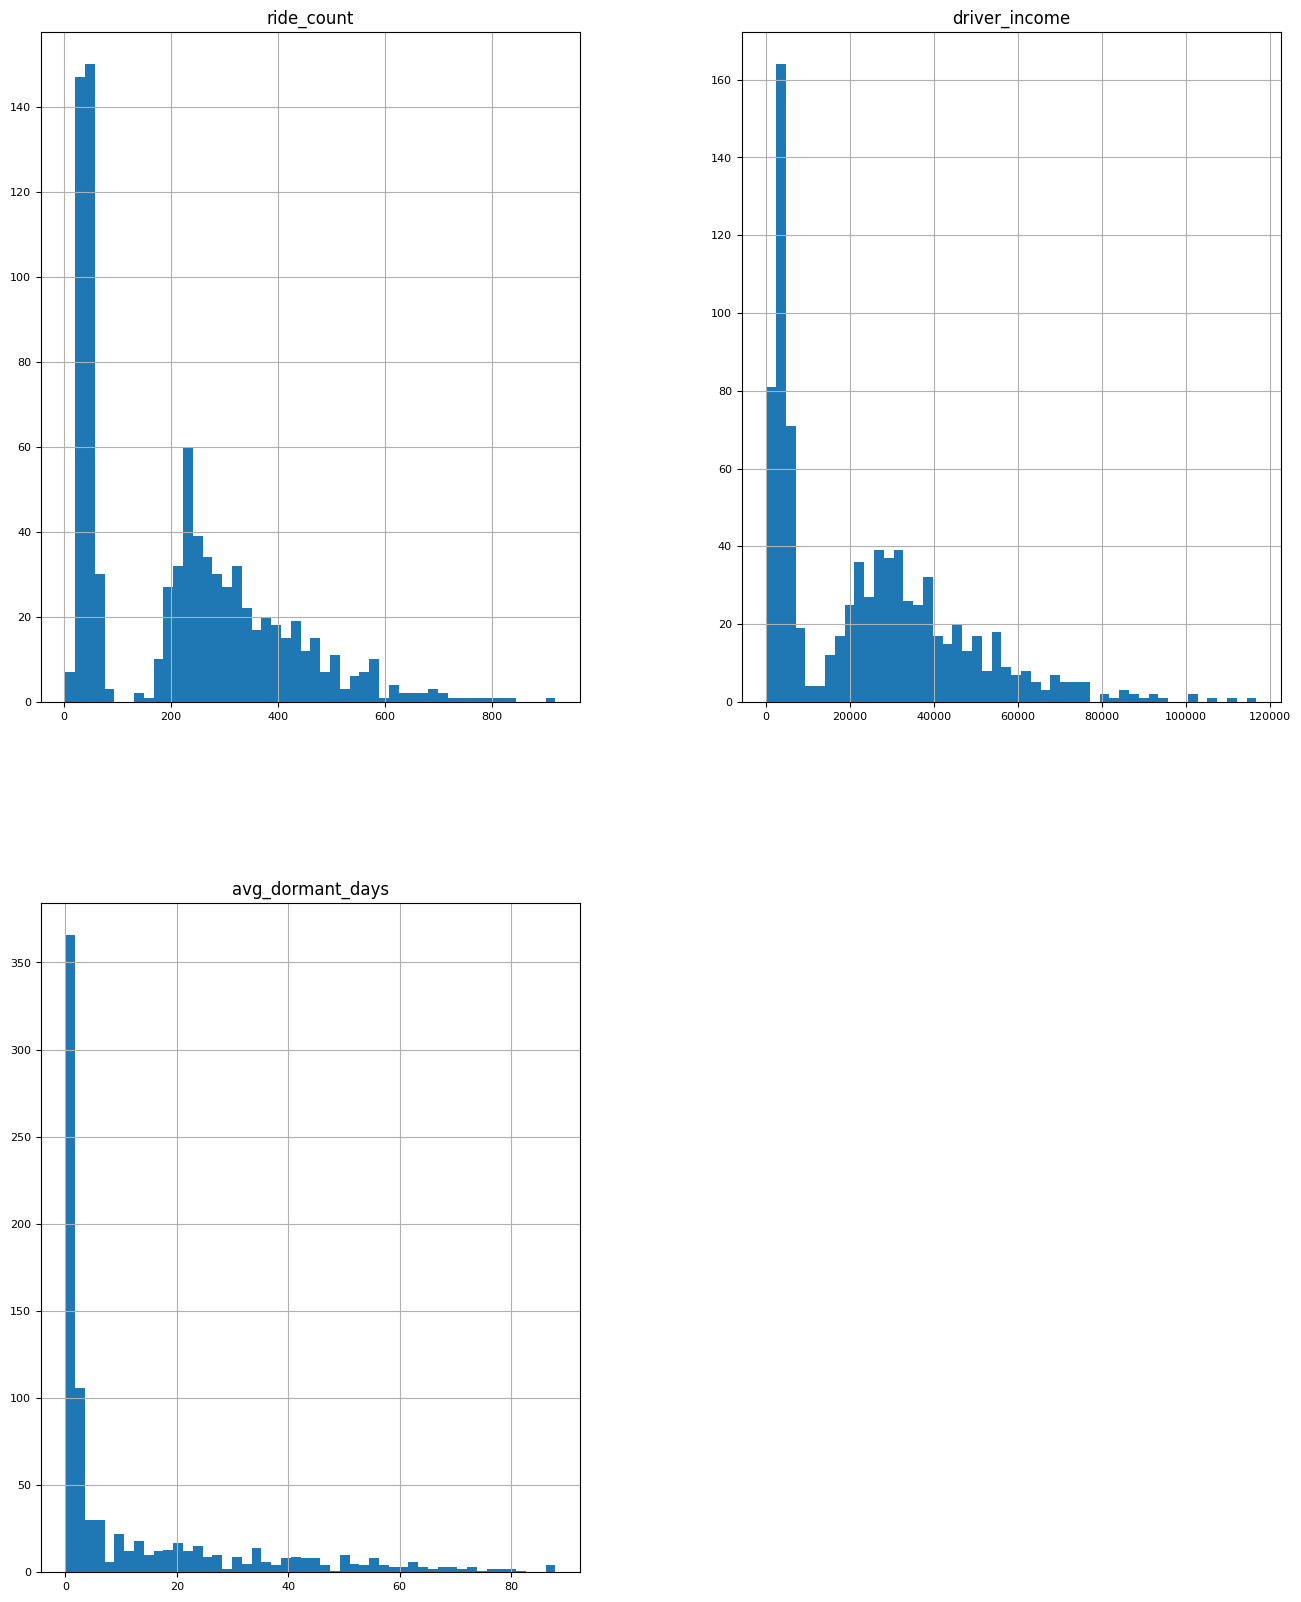

In [30]:
# Trying box-cox transformation on left-skewed that did not work with log transformation

testing = df_driver3.copy()

for col in alt_to_log:
    testing[f'{col}_boxcox'], _ = stats.boxcox(testing[col] + 1e-6)  # Adding a small constant to handle zero values
    
box_cox_trans = testing[alt_to_log]
_junk = box_cox_trans.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

For left-skewed distributions, a mixture of log and quantile transformations help best, but most of them need to be log transformed.

Even though Gaussian distributions look the most Normal, let us see if any of the transformations make them even more Normal.

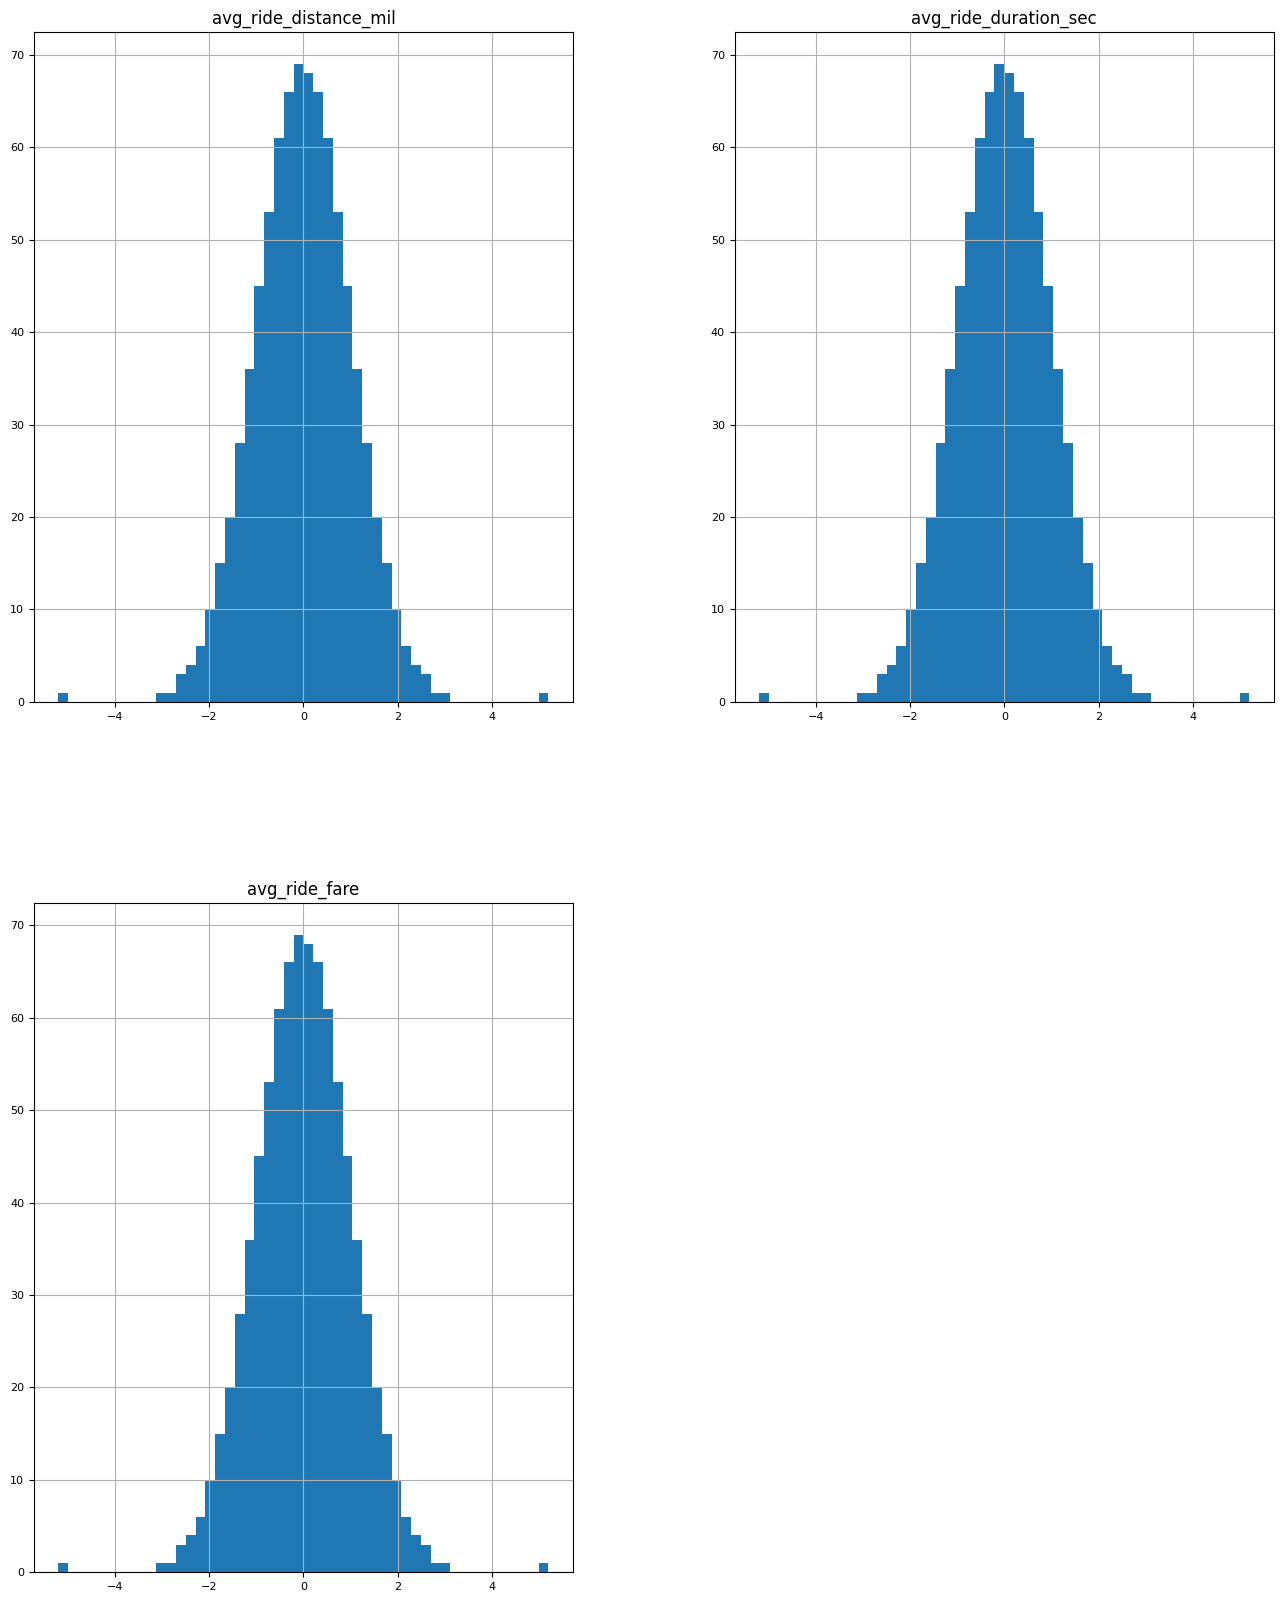

In [31]:
# Quantile on Gaussian Distributions

testing = df_driver3.copy()

# Fit and transform the selected columns
testing[gaussian] = qt.fit_transform(testing[gaussian])

compare_gaussian = testing[gaussian]

_junk = compare_gaussian.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

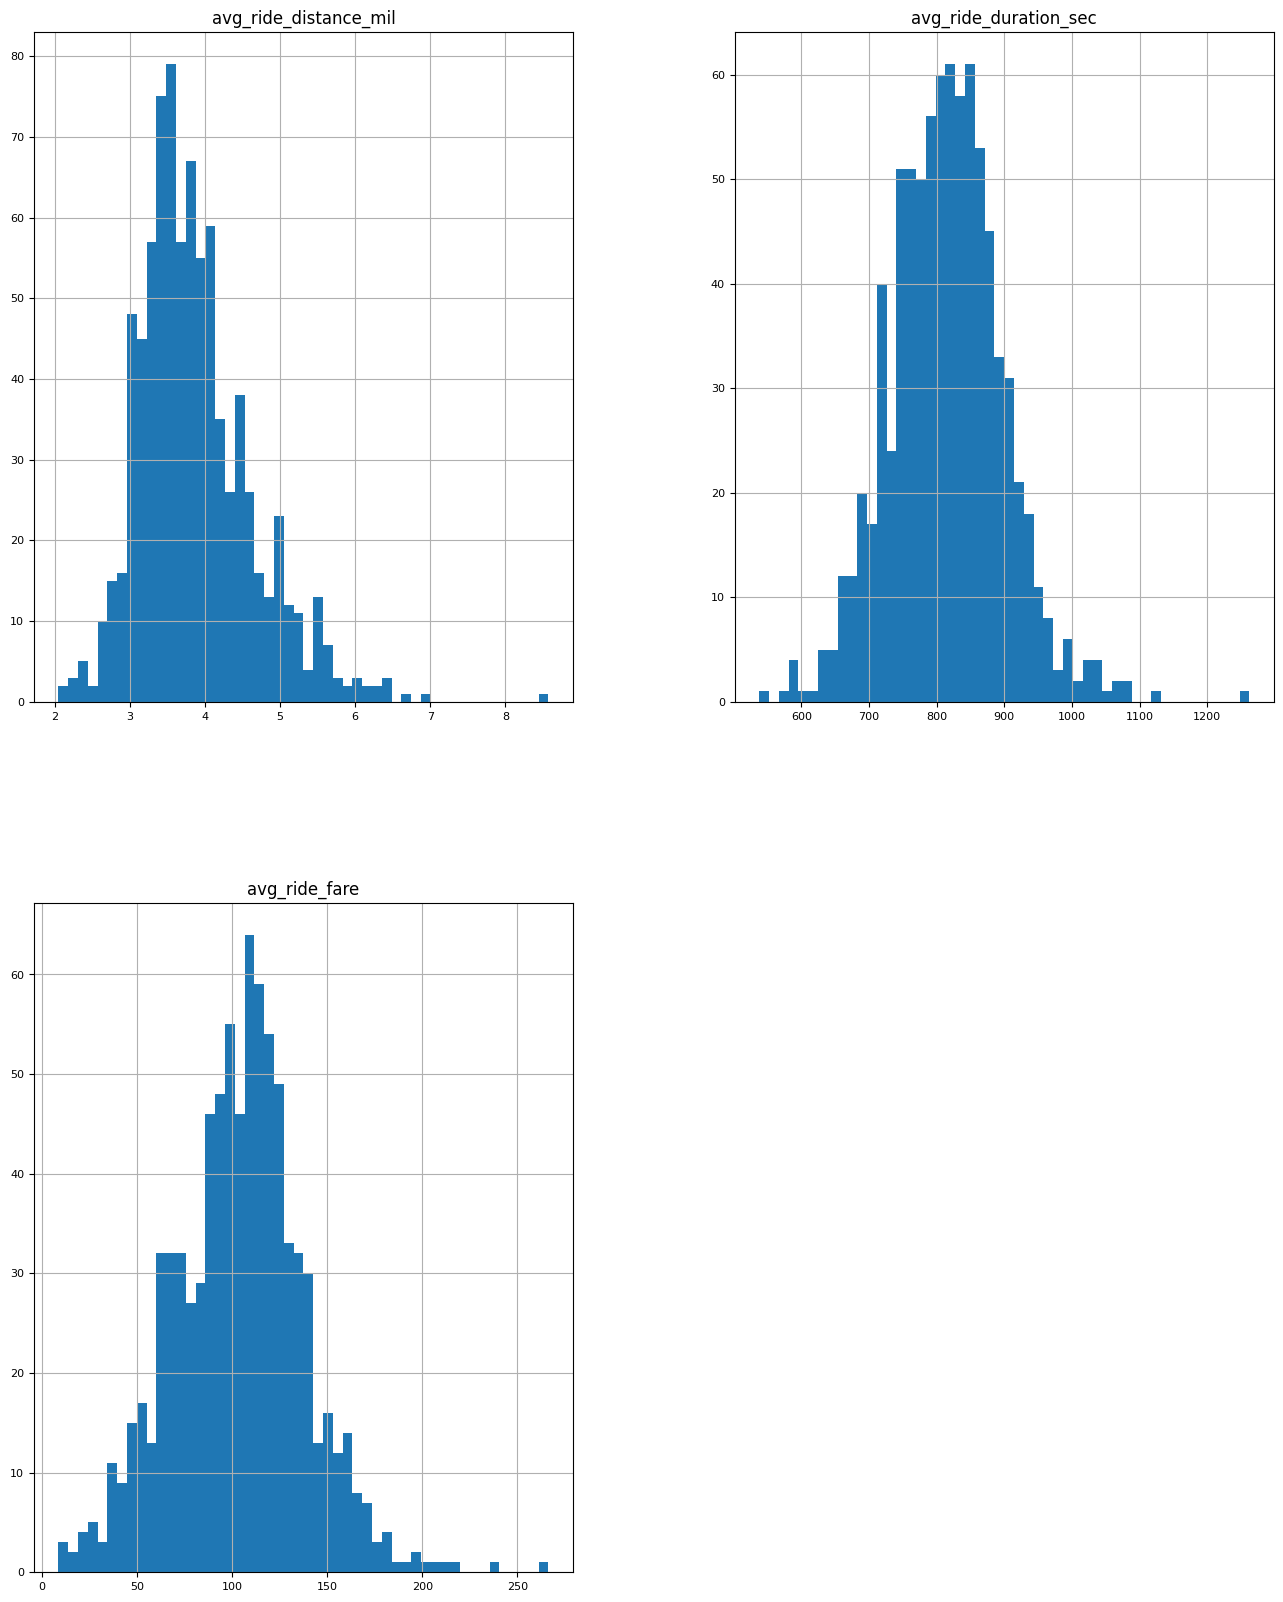

In [32]:
# Comparing Gaussians to original

_junk = df_driver3[gaussian].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

Quantile transformation made them look more normal.

In [33]:
# However, the transformation produced negative numbers.

testing['avg_ride_distance_mil'].describe()

count    8.370000e+02
mean     1.170825e-13
std      1.024484e+00
min     -5.199338e+00
25%     -6.744898e-01
50%      0.000000e+00
75%      6.744898e-01
max      5.199338e+00
Name: avg_ride_distance_mil, dtype: float64

So examining other transformations (Box-Cox and Yeo-Johnson) that make Gaussian-like distributions more Normal, but do not produce negative numbers.

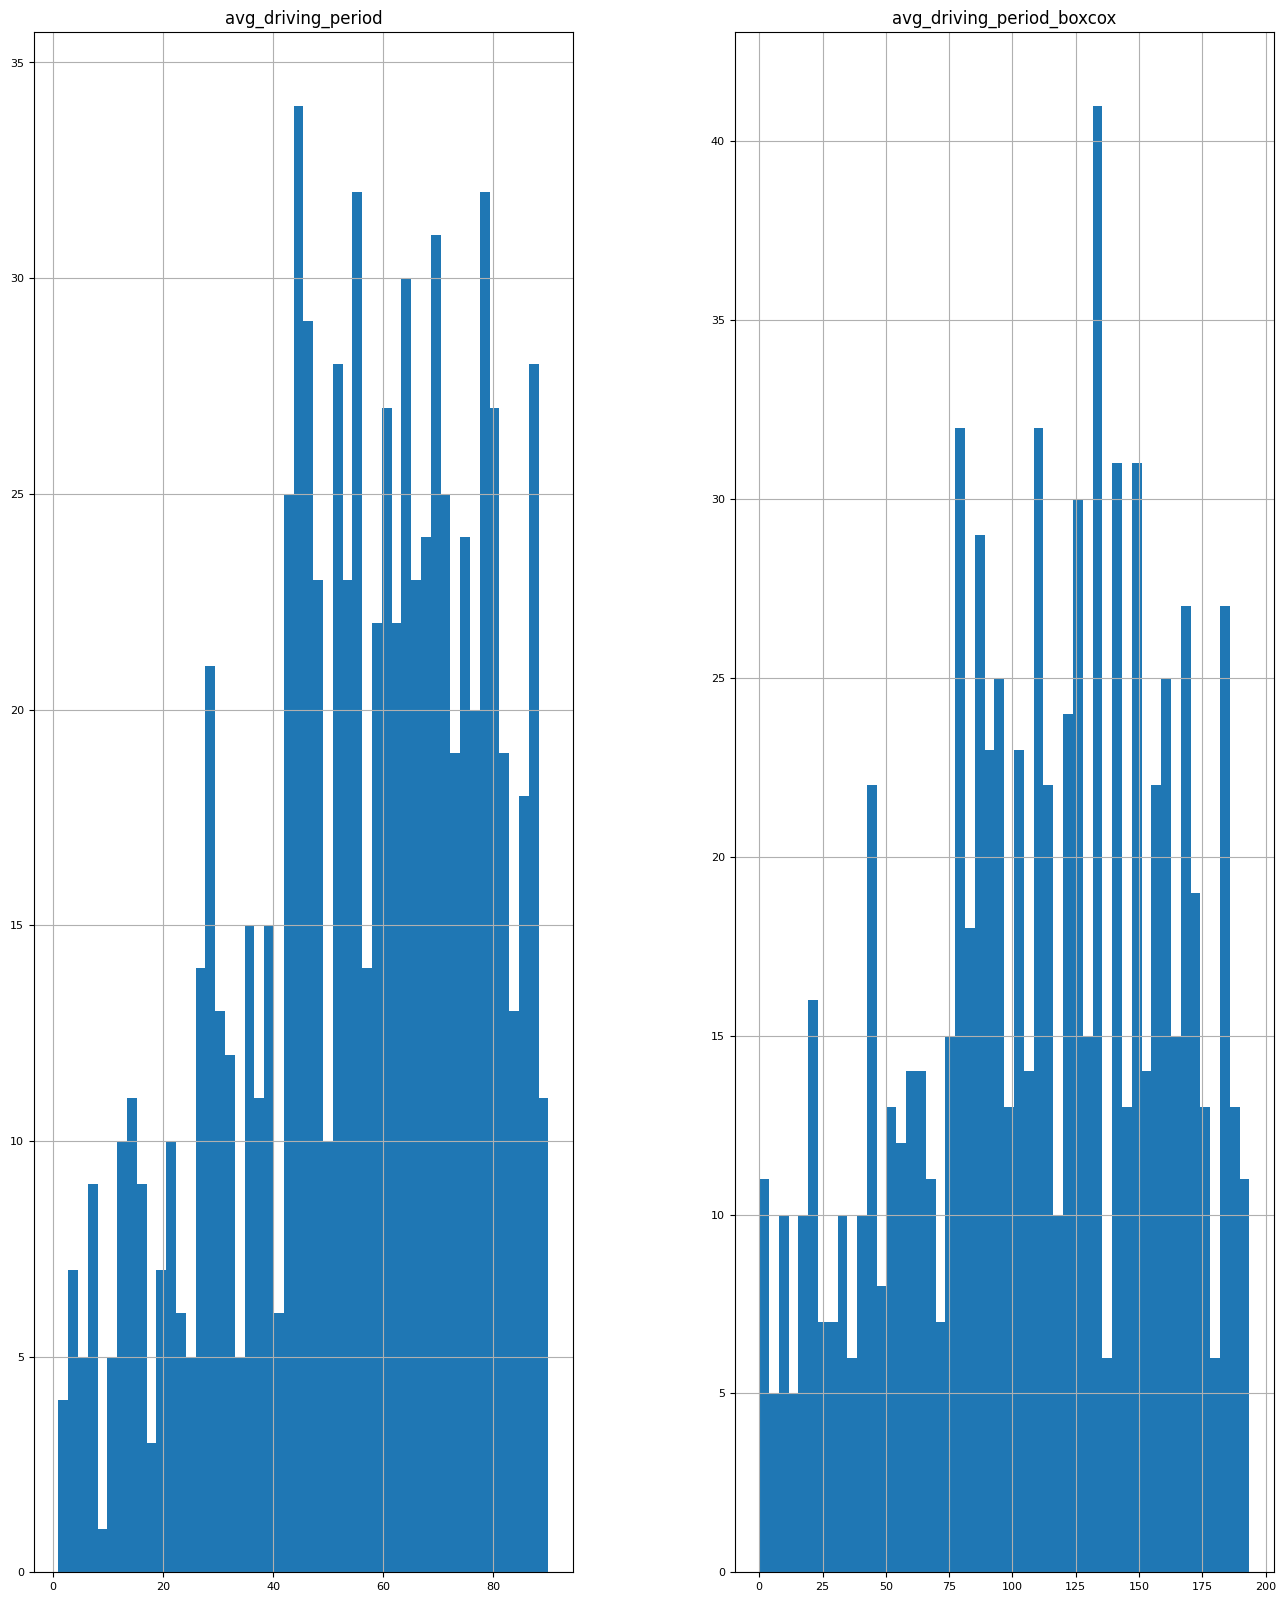

In [34]:
# Box-Cox Transformation

testing = df_driver3.copy()

for col in weibull:
    testing[f'{col}_boxcox'], _ = stats.boxcox(testing[col] + 1e-6)  # Adding a small constant to handle zero values
    
box_cox_trans = testing[['avg_driving_period', 'avg_driving_period_boxcox']]

_junk = box_cox_trans.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

Not better. So next up: try Yeo-Johnson transformation.

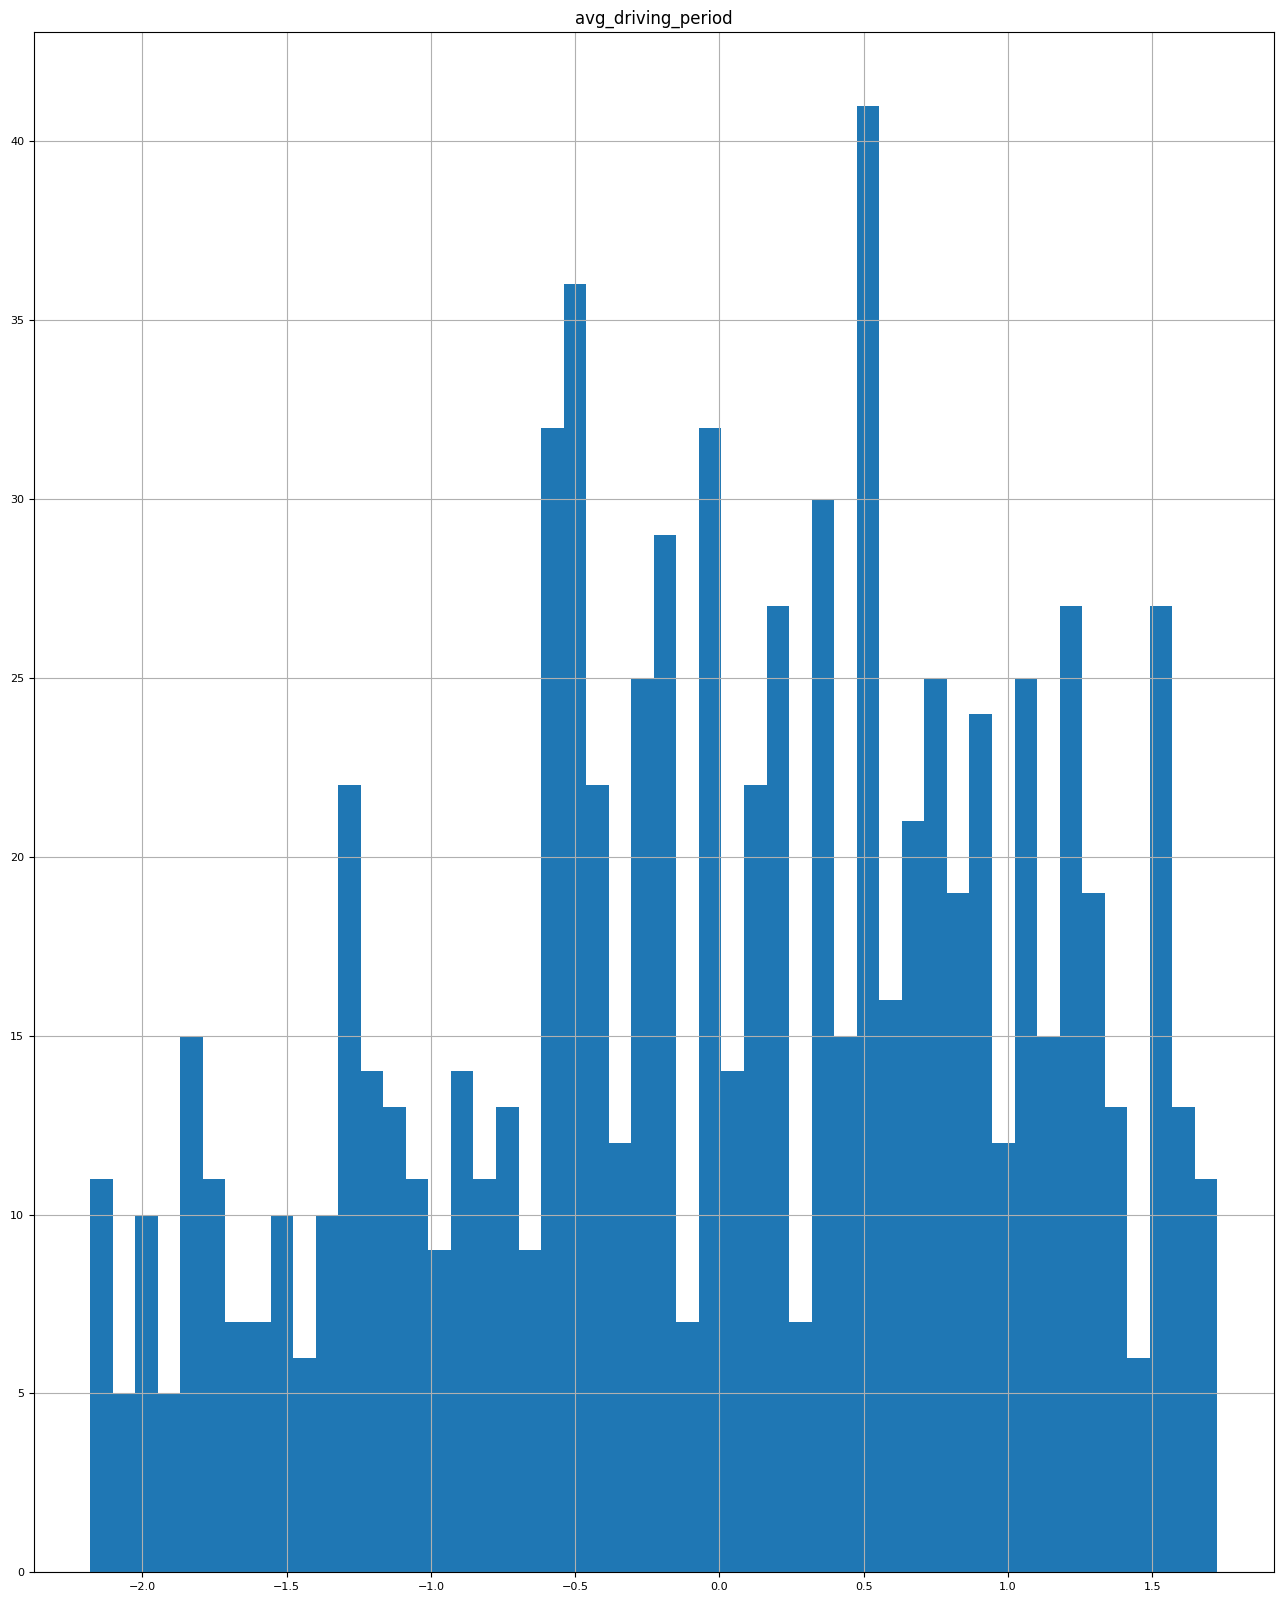

In [35]:
# Yeo-Johnson Transformation

testing = df_driver3.copy()

# Fit and transform the selected columns
testing[weibull] = pt.fit_transform(testing[weibull])

yeoj_trans = testing[['avg_driving_period']]
_junk = yeoj_trans.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

Not better. So for Gaussian distributions, Quantile transformation is best, but keep in mind the negative numbers.

Let us now move on to the next distribution type: Weibull.

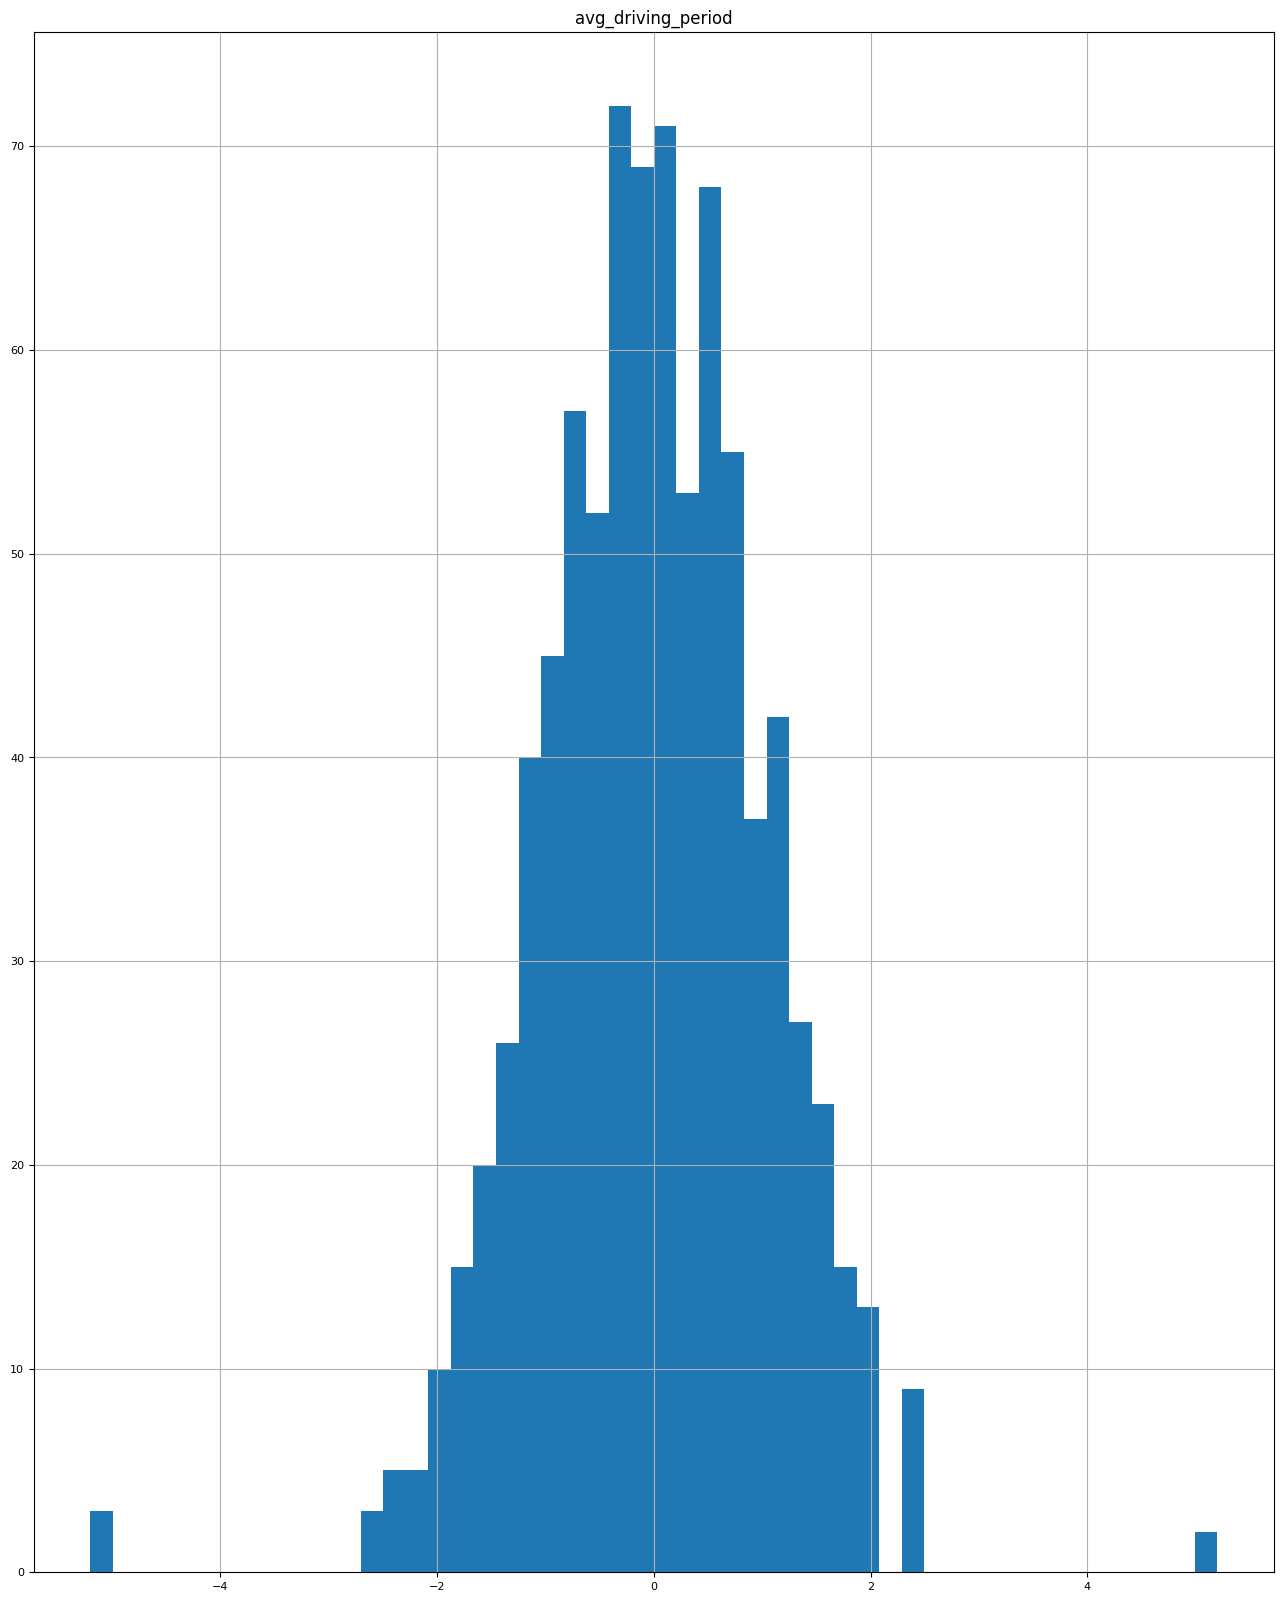

In [36]:
# Quantile Transformation on Weibull distributions

testing = df_driver3.copy()

# Fit and transform the selected columns
testing[weibull] = qt.fit_transform(testing[weibull])

compare_weibull = testing[weibull]

_junk = compare_weibull.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

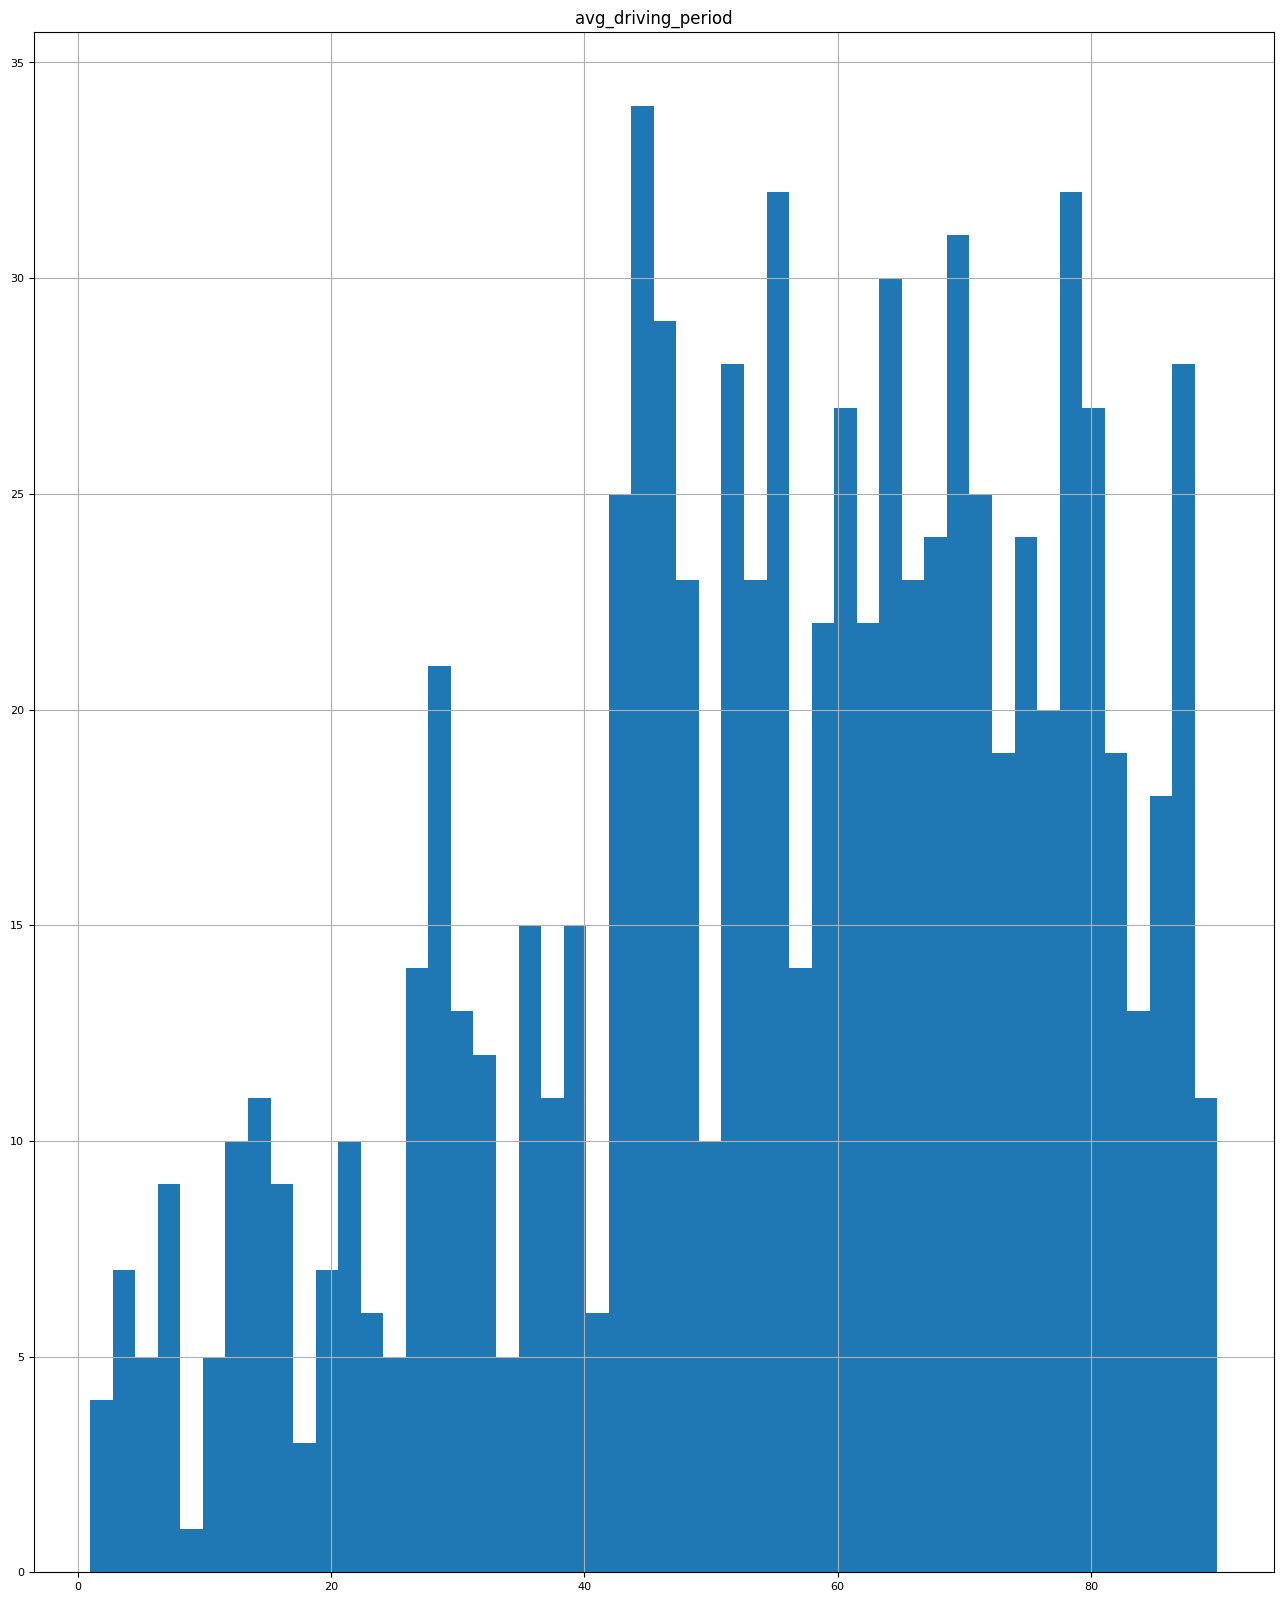

In [37]:
# Comparing Weibull distribution to Original

_junk = df_driver3[weibull].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

Quantile makes Weibull distribution look way better.

Now let us move on to the last distribution type to transform: Multimodal.

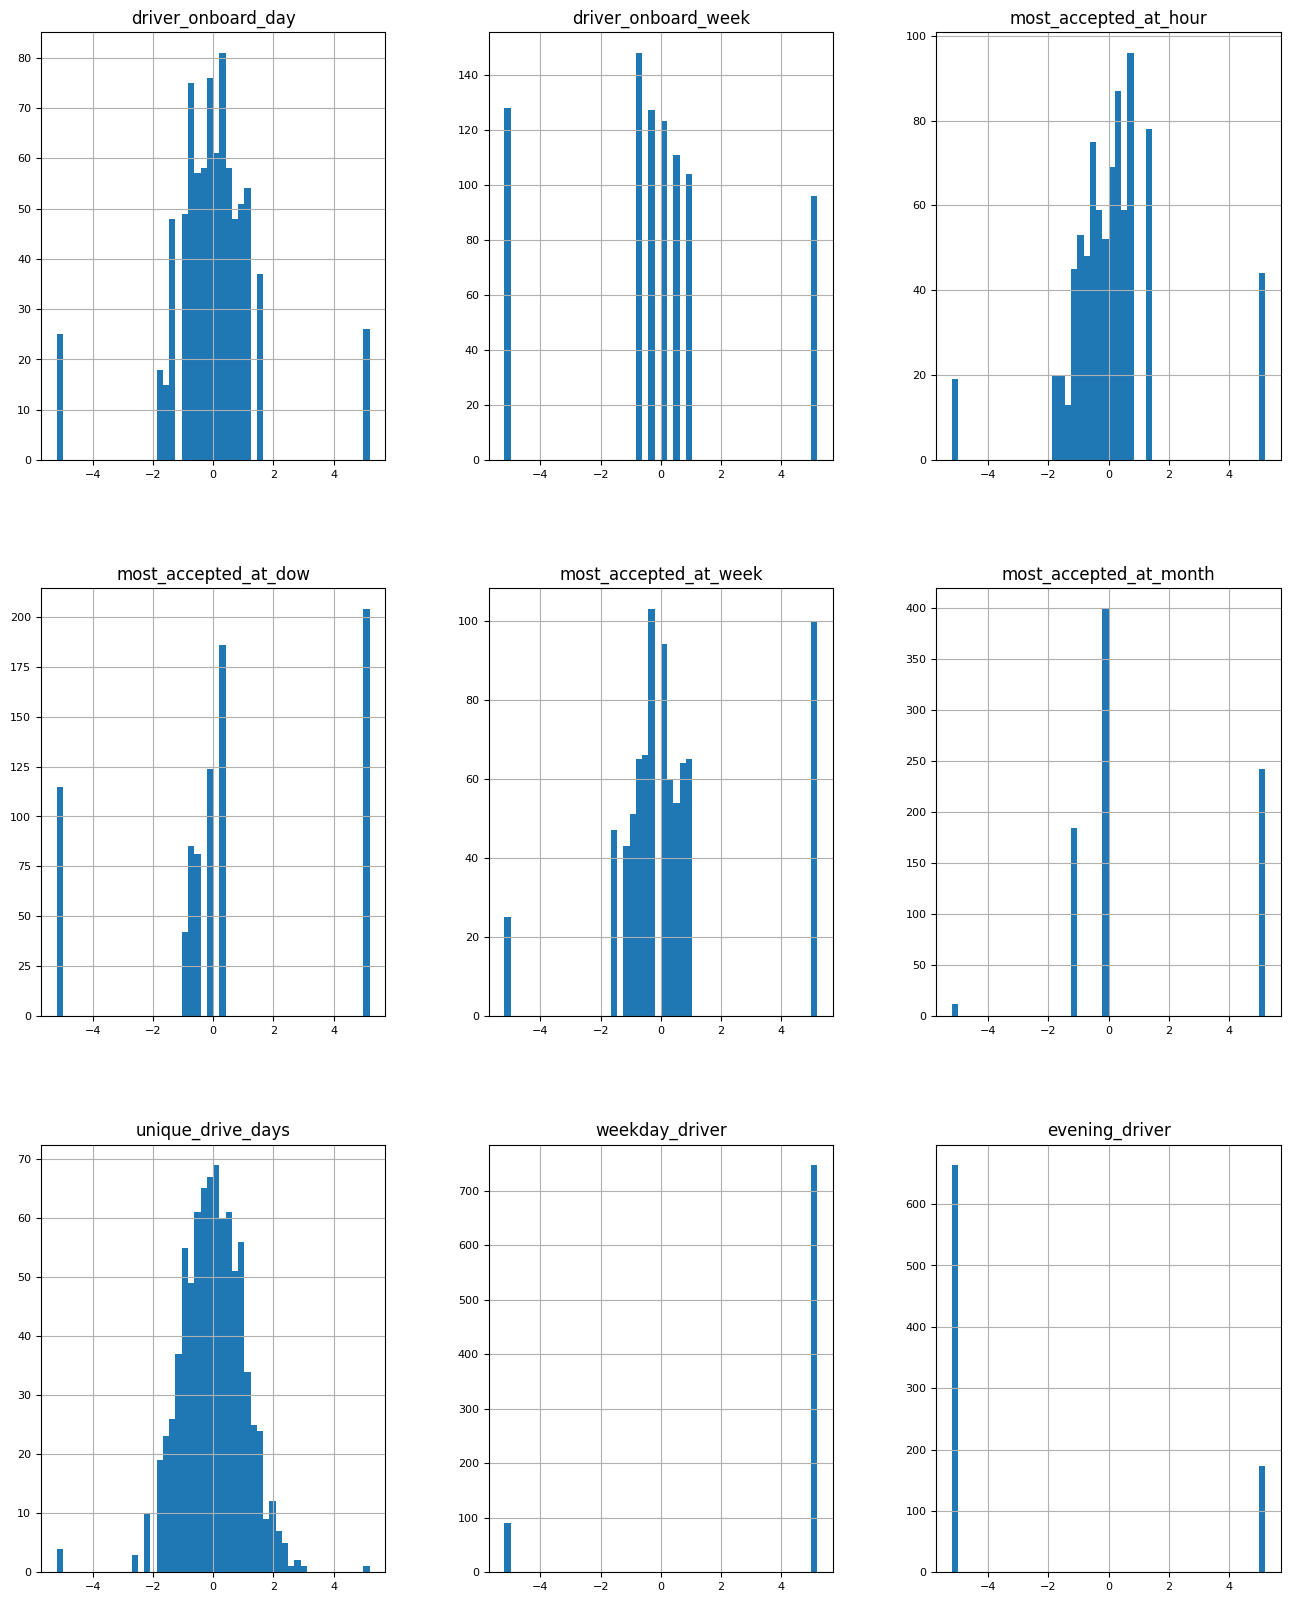

In [38]:
# Now using Quantile on Multimodal Distributions

testing = df_driver3.copy()

# Fit and transform the selected columns
testing[modal] = qt.fit_transform(testing[modal])

compare_modal = testing[modal]

_junk = compare_modal.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

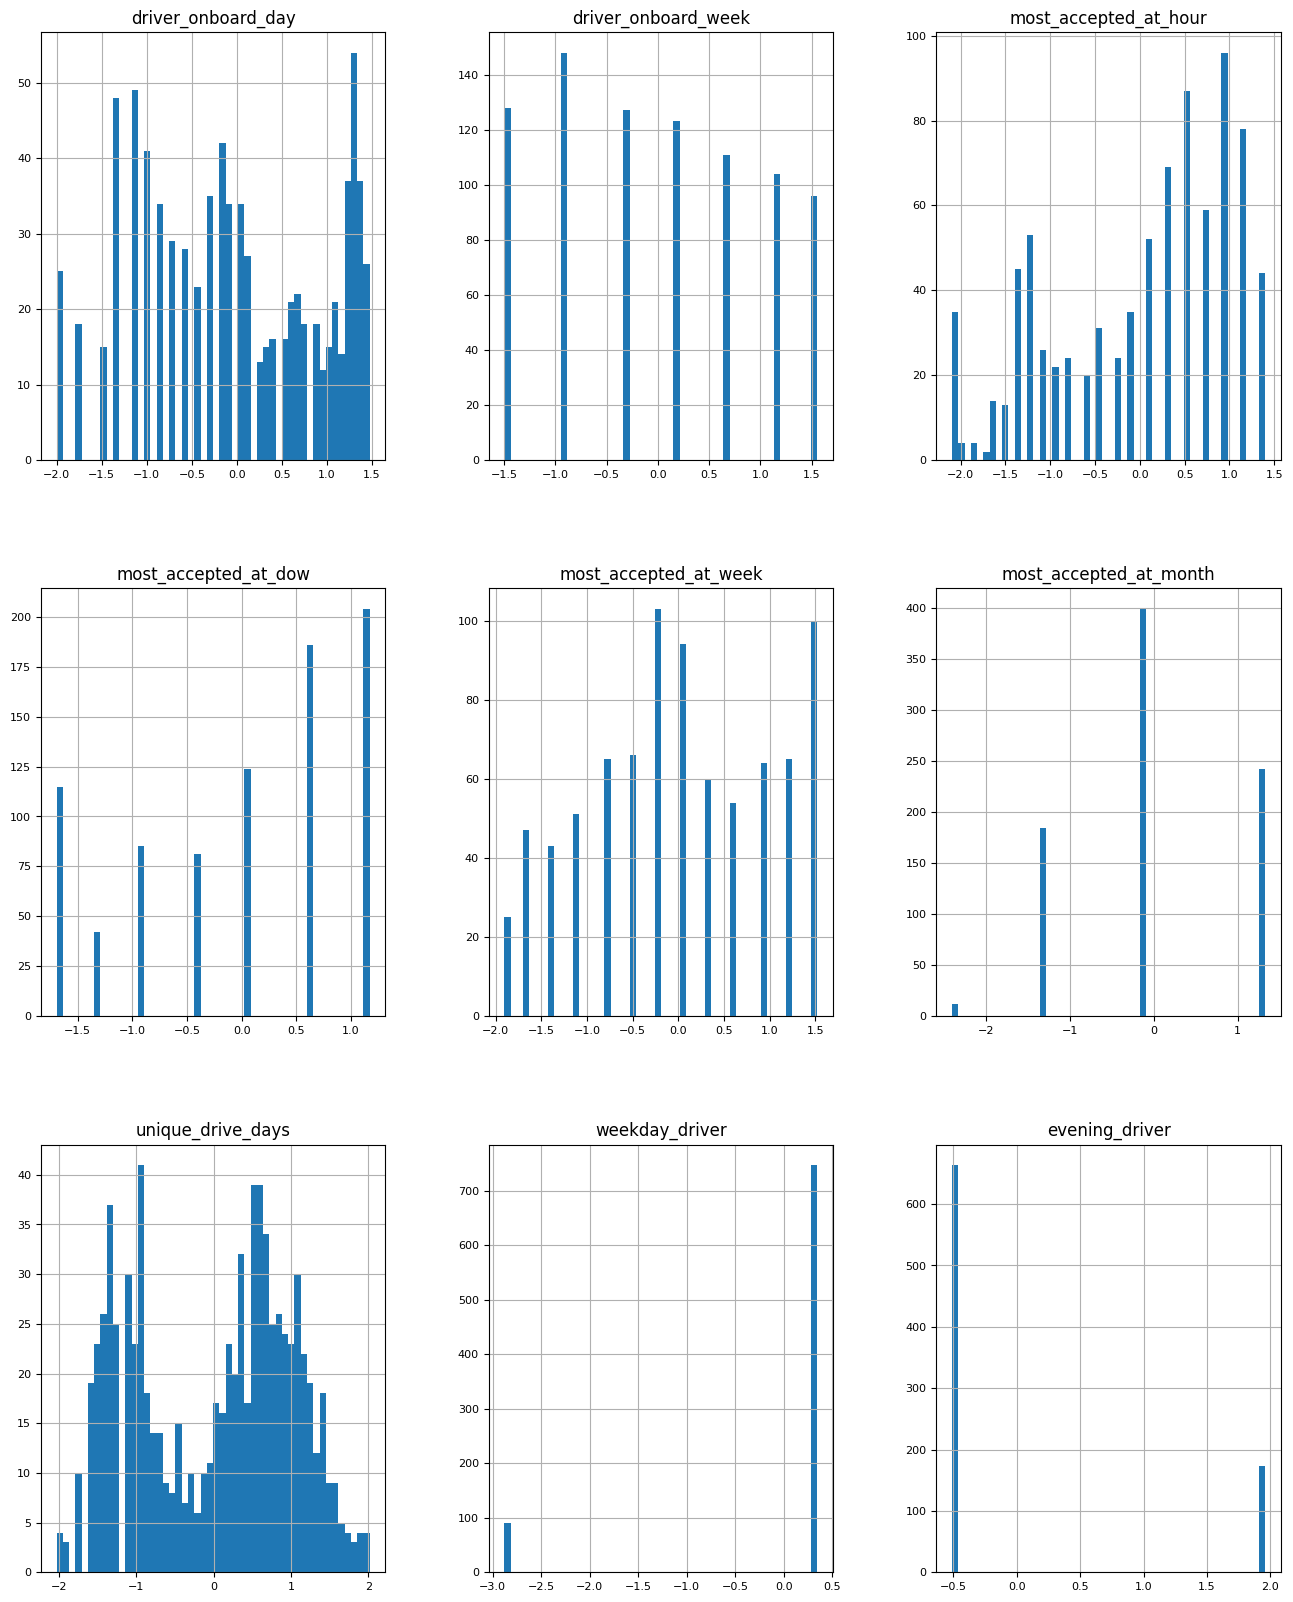

In [39]:
# Yeo-Johnson on Multimodal Distributions

testing = df_driver3.copy()

# Fit and transform the selected columns
testing[modal] = pt.fit_transform(testing[modal])

yj_modal = testing[modal]

_junk = yj_modal.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

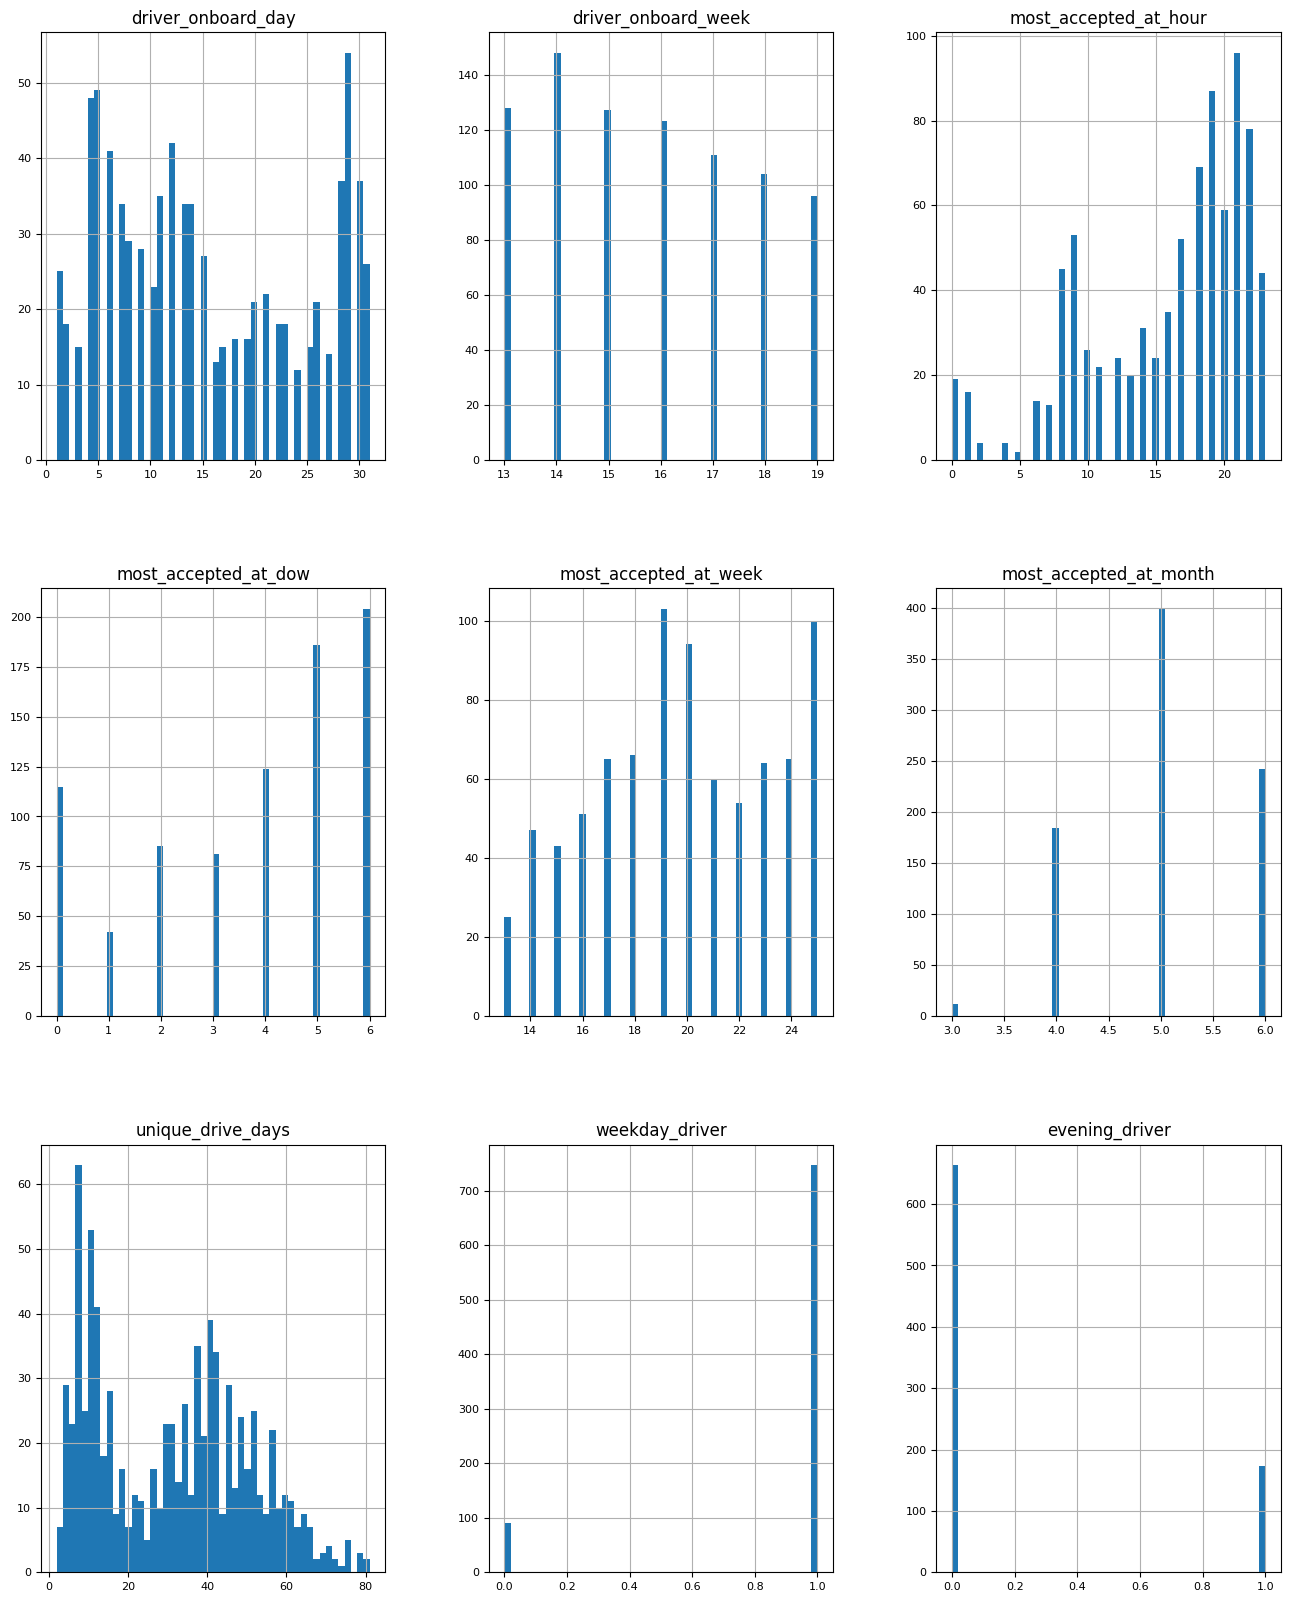

In [40]:
# Box-Cox on Multimodal Distributions
testing = df_driver3.copy()

for col in modal:
    testing[f'{col}_boxcox'], _ = stats.boxcox(testing[col] + 1e-6)  # Adding a small constant to handle zero values
    
box_cox_trans = testing[modal]
_junk = box_cox_trans.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

Quantile is the best for Multimodal distributions despite weekday_driver and evening_driver unable to change from bimodal to normal. driver_onboard_week and most_accepted_at_month are not that much different as well.

Transformation decisions on various feature distributions after trying out multiple transformation strategies:

* Gaussian: quantile
* Left Skewed: log
    ** those that did not work out with log (ride_count, driver_income, avg_dormant_days: quantile)
* Weibull: quantile
* Multimodal: quantile

So pretty much every feature will be going with quantile except those left-skewed that worked with log transformation.

1. Be careful with negative numbers after transformations
1. Remember to handle weekday_driver and evening_driver features

In [41]:
# transform columns according to recommended strategy

df_tx = df_driver3.copy()

quant_trans = gaussian + weibull + modal + ['ride_count', 'driver_income', 'avg_dormant_days']
remove_feat = ['weekday_driver', 'evening_driver']
quant_tx = [item for item in quant_trans if item not in remove_feat]

strings_to_remove = ['ride_count', 'driver_income', 'avg_dormant_days']
log_tx = [item for item in left if item not in strings_to_remove]

# Quantile Transformation
df_tx[quant_tx] = qt.fit_transform(df_tx[quant_tx])

# Log Transformation
for col in log_tx:
    df_tx[f'{col}_log'] = np.log(df_tx[col] + 1e-6)  # Adding a small constant to handle zeros
df_tx.drop(columns=log_tx, inplace=True)
df_tx.rename(columns={'avg_time_to_arrive_log':'avg_time_to_arrive',
 'avg_next_ride_lag_log':'avg_next_ride_lag',
 'average_ride_val_log':'average_ride_val',
 'average_val_log':'average_val',
 'average_ride_freq_log':'average_ride_freq',
 'ltv_log':'ltv'},inplace=True)

In [42]:
# Checking df columns (predictor and ltv target present) and column names
list(df_tx)

['driver_onboard_day',
 'driver_onboard_week',
 'avg_ride_distance_mil',
 'avg_ride_duration_sec',
 'most_accepted_at_hour',
 'most_accepted_at_dow',
 'most_accepted_at_week',
 'most_accepted_at_month',
 'ride_count',
 'avg_ride_fare',
 'driver_income',
 'weekday_driver',
 'evening_driver',
 'unique_drive_days',
 'avg_driving_period',
 'avg_dormant_days',
 'avg_time_to_arrive',
 'avg_next_ride_lag',
 'average_ride_val',
 'average_val',
 'average_ride_freq',
 'ltv']

In [43]:
# Check if negative values are present after transformations
df_tx.describe()

,driver_onboard_day,driver_onboard_week,avg_ride_distance_mil,avg_ride_duration_sec,most_accepted_at_hour,most_accepted_at_dow,most_accepted_at_week,most_accepted_at_month,ride_count,avg_ride_fare,...,evening_driver,unique_drive_days,avg_driving_period,avg_dormant_days,avg_time_to_arrive,avg_next_ride_lag,average_ride_val,average_val,average_ride_freq,ltv
count,837.000000,837.000000,8.370000e+02,8.370000e+02,837.000000,837.000000,837.000000,837.000000,837.000000,8.370000e+02,...,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,8.370000e+02,837.000000
mean,0.003980,-0.155965,1.170825e-13,1.168894e-13,0.100435,0.458514,0.335364,1.143022,-0.002179,1.170483e-13,...,0.206691,-0.006871,-0.002798,-1.300463,1.441250,3.894100,-0.359641,1.398278,1.751915e+00,8.307687
std,1.525166,2.731276,1.024484e+00,1.024484e+00,1.630834,3.202259,2.099661,2.683328,1.034542,1.024484e+00,...,0.405174,1.054933,1.053934,2.744308,0.290451,0.559724,0.998943,0.788575,4.747325e-01,0.788575
min,-5.199338,-5.199338,-5.199338e+00,-5.199338e+00,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338e+00,...,0.000000,-5.199338,-5.199338,-5.199338,0.559616,1.098613,-2.181397,-0.303072,9.999995e-07,6.606336
25%,-0.659508,-0.702997,-6.744898e-01,-6.744898e-01,-0.682037,-0.710696,-0.714561,-0.067514,-0.680147,-6.744898e-01,...,0.000000,-0.661373,-0.678259,-5.199338,1.233532,3.533575,-1.160750,0.825053,1.458615e+00,7.734462
50%,-0.043490,0.138365,0.000000e+00,0.000000e+00,0.060003,-0.100615,0.085558,-0.067514,-0.005997,0.000000e+00,...,0.000000,-0.022490,-0.010494,-0.053997,1.414465,3.904369,-0.654627,1.199335,1.824549e+00,8.108744
75%,0.672609,0.510005,6.744898e-01,6.744898e-01,0.831834,0.372756,0.722323,5.199338,0.670730,6.744898e-01,...,0.000000,0.689624,0.704918,0.682037,1.614978,4.278418,0.556739,1.923541,2.098204e+00,8.832950
max,5.199338,5.199338,5.199338e+00,5.199338e+00,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338e+00,...,1.000000,5.199338,5.199338,5.199338,2.484907,5.752890,1.957617,3.734984,2.862201e+00,10.644393


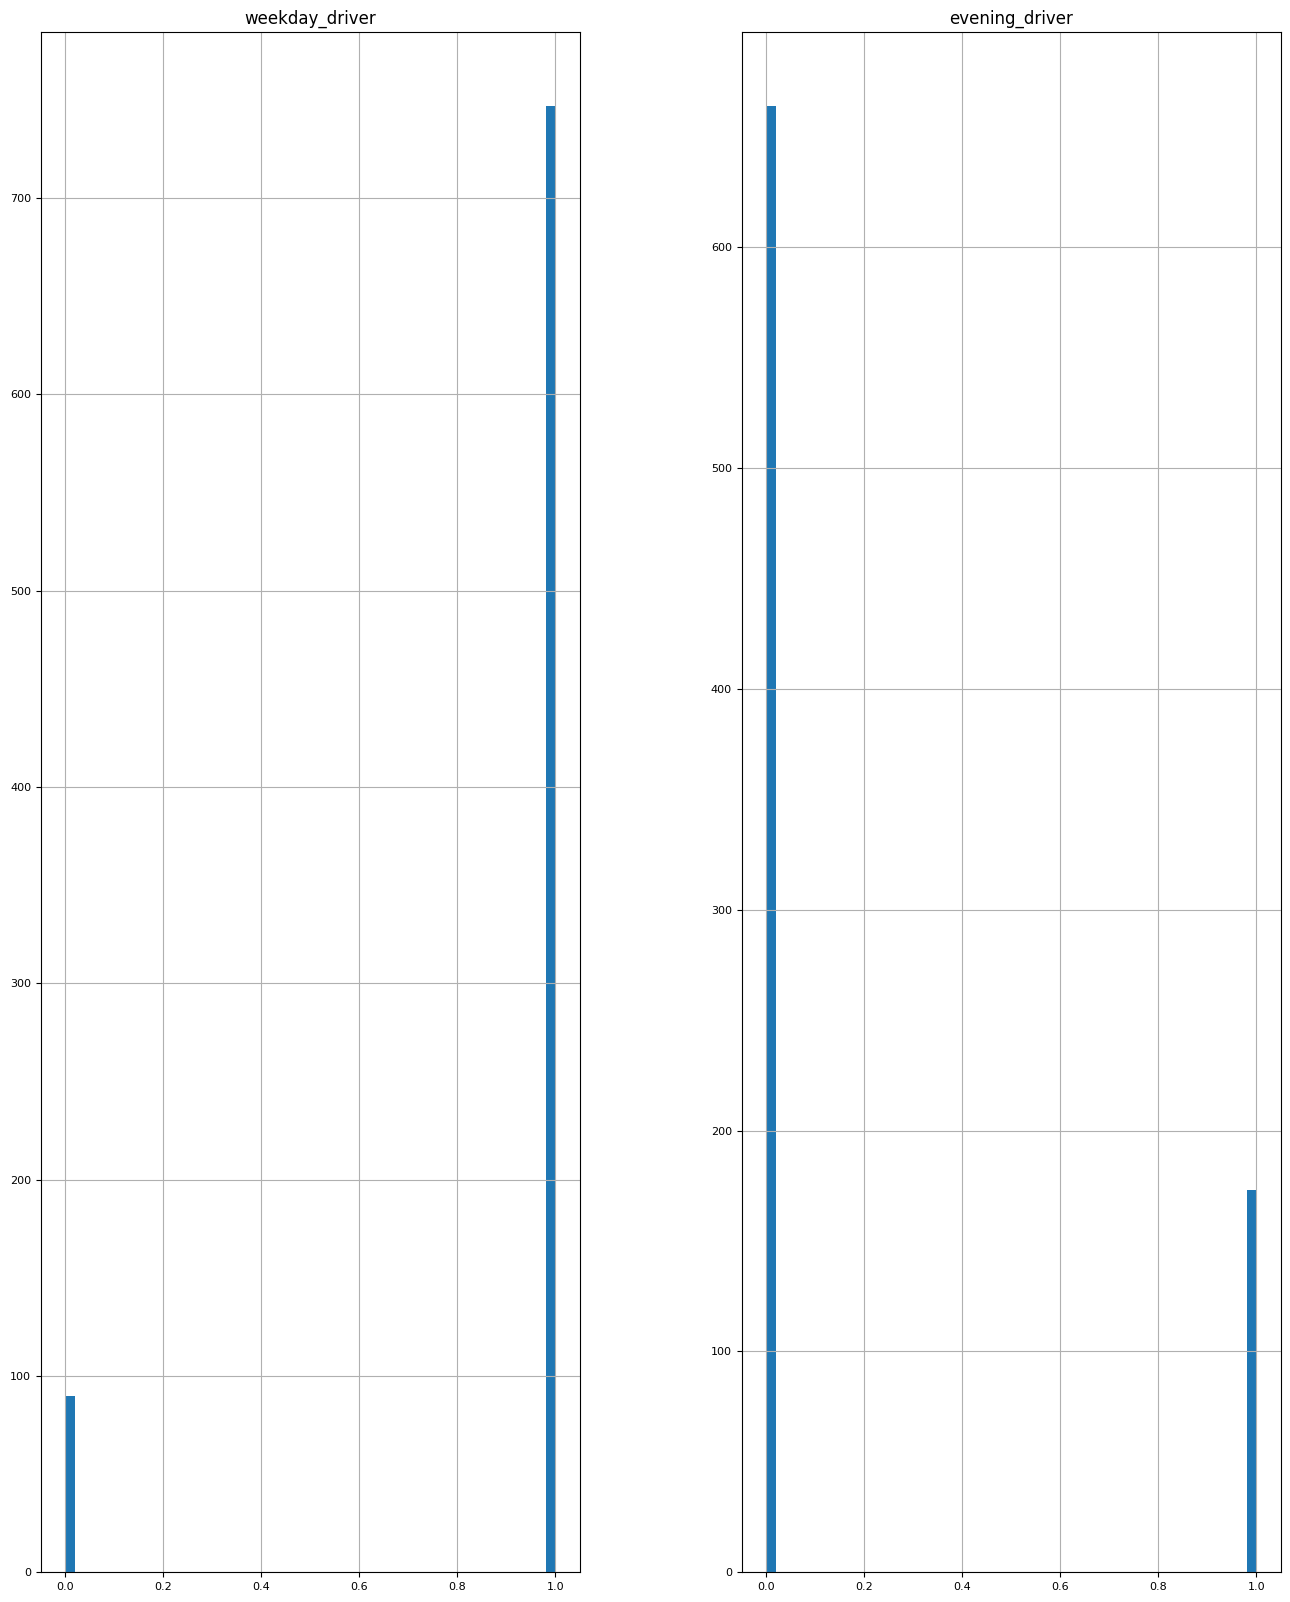

In [44]:
# checking weekday_driver and evening_driver distributions at this point
# So that we know what we are feeding into the modeling algorithm

check = df_tx[['weekday_driver', 'evening_driver']]

_junk = check.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

# Feature Scaling 
If we solely go with tree models then this is not necessary.

In [45]:
# Robust Scaler is robust to outliers

scaler = RobustScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_tx), columns=df_tx.columns)

___
# Modeling 

We suspect that features that violate Linear Regression assumption such as Normality and imbalanced data in (discrete and categorical variables) will affect model performance negatively. 

So we will systematically go through different models from basic to complex to reach the best performing model that captures the trends in data and has the best predictive power with unseen data.

Order of Candidate Models from simple to complex:
1. Linear Regression
2. Extra Trees Regressor (Tree-based to try out since assuming features to target is strictly linear is restrictive. This will be done on pre-processed data even though tree-based models are robust to heterogeneous data)
3. Regularization of Linear Regression model with Ridge
4. Regularization of Linear Regression model with Lasso
5. Bagging Method (Random Forest Regressor)
6. Boosting Method (Gradient Boosting Regressor, XGBoost)
7. Stacking Method (Decision Tree, Random Forest and SVR as base models + Linear Regression as meta learner)

Before running any models, we need to define our metric of interest as guideline to how we measure each model's performance.

# Metric of Interest: RMSE

### Baseline model (to compare others to with expectation that others will perform better)

In [46]:
# Linear Regression

# prepare train and test sets
X = df_scaled.loc[:, df_scaled.columns != 'ltv']
y = df_scaled['ltv']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state =42)

# create model object
lr = LinearRegression()

# fit training data onto model object
lr.fit(X_train, y_train)

# predict target values on unseen data using trained model
y_pred = lr.predict(X_test)

# assess model performance using true labels and predicted values
mse = mean_squared_error(y_test, y_pred)
lr_rmse = np.sqrt(mse)
"{:.16f}".format(lr_rmse)

'0.0000000858292369'

This will be hard to beat.

## Trying other models in order to see if there is a more 'realistic' performance output, but it just might be the case that the relationship between features and target are a strong linear process.

In [47]:
# Extra Trees Regressor - when want to lower possibility of variance/overfitting, alternative to Random Forest

# Initialize the Extra Trees Regressor
extra_trees_model = ExtraTreesRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
extra_trees_model.fit(X_train, y_train)

# Predict on the test set
y_pred = extra_trees_model.predict(X_test)

# Calculate and print RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Extra Trees Regressor RMSE: {rmse}')

Extra Trees Regressor RMSE: 0.018104079190702328


Not bad, but still not as good as base model - Linear Regression. Let's try another modeling method that assumes prior methods have overfit and therefore needs Regularization. This aims to reduce the complexity of models. It significantly reduces variance while only slightly increasing bias. Most widely used forms are L1 (lasso) and L2 (ridge).

This is just one of many ways we can improve model prediction accuracy. Let us review other strategies before attempting Regularization. Then we can decide on our final model to best represent the relationship between features and LTV.
---
Optimizing a machine learning model involves improving its performance, generalization, and robustness. Various strategies and industry standards are used depending on the problem, dataset, and model type. Here’s an overview of the most common techniques and best practices:

### 1. **Data Preprocessing and Feature Engineering**
   - **Data Cleaning**: Handling missing values, outliers, and inconsistent data entries ensures the model learns effectively from the data.
   - **Feature Scaling**: Normalizing or standardizing features (using methods like MinMaxScaler, StandardScaler) ensures that all features contribute equally to the model, especially important for models that rely on distance metrics (e.g., SVM, k-NN).
   - **Feature Transformation**: Applying transformations like **log**, **Box-Cox**, **Yeo-Johnson**, or **quantile transformation** can help normalize skewed data or stabilize variance.
   - **Feature Selection**: Eliminating irrelevant or redundant features can improve performance and reduce overfitting. Techniques include **recursive feature elimination (RFE)**, **L1 regularization (Lasso)**, and **mutual information**.
   - **Dimensionality Reduction**: Methods like **Principal Component Analysis (PCA)** and **t-SNE** reduce the number of features while preserving important information, helping models run faster and generalize better.
   - **Handling Imbalanced Data**: For classification tasks with skewed class distributions, techniques like **oversampling (SMOTE)**, **undersampling**, or **cost-sensitive learning** can help the model focus on minority classes.

### 2. **Model Selection and Tuning**
   - **Algorithm Selection**: Choose the right model based on the problem type, dataset size, and the complexity of the data. For example, linear models (like linear regression) may perform better on smaller datasets, while complex models (like gradient boosting machines) handle larger, non-linear relationships.
   - **Regularization**: Adding penalties (e.g., **L1 regularization** for Lasso or **L2 regularization** for Ridge) can prevent overfitting by constraining large coefficients and forcing the model to be simpler.
   - **Hyperparameter Tuning**:
     - Use techniques like **Grid Search** or **Random Search** to find the best hyperparameters. This can be done in conjunction with cross-validation to ensure generalization.
     - **Bayesian Optimization**, **Genetic Algorithms**, and **Tree-structured Parzen Estimators (TPE)** can also be used for more advanced hyperparameter tuning, especially for complex models.
   - **Cross-Validation**: Instead of relying on a single train-test split, use **k-fold cross-validation** to get a more reliable estimate of model performance. It helps reduce overfitting and improves model stability.
   - **Ensemble Methods**:
     - **Bagging (e.g., Random Forest)**: Combines multiple weak learners (e.g., decision trees) to reduce variance and prevent overfitting.
     - **Boosting (e.g., XGBoost, LightGBM, AdaBoost)**: Sequentially trains weak learners, where each learner tries to correct the mistakes of the previous one, reducing bias and improving accuracy.
     - **Stacking**: Combines different models (e.g., logistic regression, decision trees, SVM) and uses another model (meta-learner) to combine their predictions.

### 3. **Regularization Techniques**
   - **L1 Regularization (Lasso)**: Shrinks some coefficients to zero, effectively performing feature selection, which can reduce overfitting by simplifying the model.
   - **L2 Regularization (Ridge)**: Penalizes large coefficients by shrinking them, reducing model complexity and preventing overfitting.
   - **Elastic Net**: Combines both L1 and L2 penalties, useful when features are highly correlated.

### 4. **Advanced Optimization Techniques**
   - **Gradient Descent Variants**:
     - **Stochastic Gradient Descent (SGD)**: Updates model weights incrementally using small batches of data, speeding up training.
     - **Adam Optimizer**: An adaptive learning rate method, combining the advantages of RMSprop and Momentum, particularly useful for deep learning models.
   - **Learning Rate Scheduling**: Adjusts the learning rate over time (e.g., exponential decay, cosine annealing) to ensure the model converges efficiently without overshooting the optimal point.
   - **Batch Normalization**: Normalizes layer inputs to stabilize and speed up training in deep learning models.
   - **Early Stopping**: Monitors validation performance and stops training when the performance on the validation set begins to deteriorate, preventing overfitting.

### 5. **Handling Overfitting**
   - **Cross-Validation**: k-fold cross-validation helps ensure the model generalizes well and reduces overfitting by averaging the performance across multiple train-test splits.
   - **Regularization**: Use L1 or L2 regularization techniques to penalize overly complex models.
   - **Dropout (for Neural Networks)**: Randomly drops neurons during training to prevent overfitting by forcing the network to learn robust representations.

### 6. **Hyperparameter Optimization**
   - **Grid Search**: Exhaustively searches through a manually specified subset of hyperparameters.
   - **Random Search**: Randomly samples the hyperparameter space, faster and often as effective as grid search.
   - **Bayesian Optimization**: More sophisticated than random search, Bayesian optimization builds a probabilistic model to find the best hyperparameters by learning from previously evaluated configurations.
   - **Hyperband/Successive Halving**: Efficient resource allocation strategies that evaluate many configurations and discard poor performers early.

### 7. **Ensemble Learning**
   - **Bagging**: Combines predictions from multiple models (e.g., Random Forest), reducing variance and avoiding overfitting.
   - **Boosting**: Sequentially improves models (e.g., XGBoost, LightGBM) by focusing on errors made by previous models, reducing both bias and variance.
   - **Stacking**: Combines multiple base models and uses another model to aggregate their predictions, improving prediction accuracy by leveraging the strengths of different models.

### 8. **Neural Network-Specific Techniques**
   - **Batch Normalization**: Helps in stabilizing and speeding up the training process by normalizing layer inputs.
   - **Dropout**: Prevents overfitting by randomly dropping units (neurons) during training.
   - **Learning Rate Scheduling**: Adjusts learning rate dynamically to improve convergence (e.g., using a scheduler like ReduceLROnPlateau).

### 9. **Monitoring and Debugging**
   - **Performance Metrics**:
     - Track different metrics like **Accuracy**, **Precision**, **Recall**, **F1-Score**, or **AUC** for classification problems, and **RMSE**, **R-squared** for regression problems to assess model performance.
   - **Learning Curves**: Plot the learning curves (training vs. validation loss over time) to detect overfitting or underfitting early.
   - **Confusion Matrix**: Analyze the confusion matrix for classification models to better understand model performance across different classes.
   - **Residual Plots**: For regression, plotting residuals can help detect patterns that indicate poor fit (e.g., non-linearity or heteroscedasticity).

### 10. **Post-Training Optimization**
   - **Model Compression**: For large neural networks, techniques like **pruning**, **quantization**, and **knowledge distillation** can reduce model size and make inference faster, useful for deployment in resource-constrained environments.
   - **Model Interpretability**: Use techniques like **LIME**, **SHAP**, or **feature importance** to interpret black-box models, ensuring transparency and trust in predictions.

### Summary of Strategies:
- **Data Preprocessing**: Ensure clean and well-engineered features.
- **Model Selection**: Choose the appropriate model based on problem complexity and data size.
- **Hyperparameter Tuning**: Systematically search for the best hyperparameters.
- **Regularization**: Control model complexity to avoid overfitting.
- **Cross-Validation**: Validate the model across different data splits to ensure generalization.
- **Ensemble Methods**: Combine multiple models for robust performance.
- **Advanced Optimization**: Use techniques like gradient descent variants and early stopping.

By following these industry-standard strategies, you can systematically optimize machine learning models for better performance, generalization, and robustness.

In [48]:
# Lasso and Ridge are brought in when need to reduce variance/overfitting the training data

# Initialize Ridge model
ridge = Ridge()

# Define a grid of hyperparameters for tuning alpha (regularization strength)
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Perform grid search with 5-fold cross-validation
ridge_cv = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the model on the training data
ridge_cv.fit(X_train, y_train)

# Get the best alpha value
best_alpha_ridge = ridge_cv.best_params_['alpha']
print(f"Best alpha for Ridge: {best_alpha_ridge}")

# Fit the Ridge model with the best alpha
ridge_best = Ridge(alpha=best_alpha_ridge)
ridge_best.fit(X_train, y_train)

# Predict on test set
y_pred_ridge = ridge_best.predict(X_test)

# Calculate RMSE
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
print(f"RMSE for Ridge: {rmse_ridge}")

Best alpha for Ridge: 0.01
RMSE for Ridge: 0.0001084712786872905


This beat Extra Trees Regressor, but not Linear Regression. Let's now try Lasso.

In [49]:
# Initialize Lasso model
lasso = Lasso()

# Define a grid of hyperparameters for tuning alpha
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Perform grid search with 5-fold cross-validation
lasso_cv = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the model on the training data
lasso_cv.fit(X_train, y_train)

# Get the best alpha value
best_alpha_lasso = lasso_cv.best_params_['alpha']
print(f"Best alpha for Lasso: {best_alpha_lasso}")

# Fit the Lasso model with the best alpha
lasso_best = Lasso(alpha=best_alpha_lasso)
lasso_best.fit(X_train, y_train)

# Predict on test set
y_pred_lasso = lasso_best.predict(X_test)

# Calculate RMSE
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
print(f"RMSE for Lasso: {rmse_lasso}")

Best alpha for Lasso: 0.01
RMSE for Lasso: 0.014606725909125979


This did worse than Ridge. So from best to worst: base Linear Regression > Ridge > Lasso.

## Ensemble Methods

* Bagging (e.g., Random Forest): Combines multiple weak learners (e.g., decision trees) to reduce variance (prevent overfitting).

* Boosting (e.g., XGBoost, LightGBM, AdaBoost): Sequentially trains weak learners, where each learner tries to correct the mistakes of the previous one, reducing bias (prevent underfitting) and improving accuracy.

* Stacking: Combines different models (e.g., logistic regression, decision trees, SVM) and uses another model (meta-learner) to combine their predictions.

Gradient boosting might be overkill, but still let us try it out.

### Bagging

In [50]:
# Bagging using Random Forest

# Define the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100,  # Number of trees
                                 max_features='sqrt',  # Use sqrt(number of features) at each split
                                 random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

RMSE: 0.11960172798735379


This is the worst performing model so far. However, let us try and optimize some model parameters to try and enhance the Random Forest's performance.

In [51]:
%%timeit

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV with RandomForestRegressor
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), 
                           param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=5)

# Fit grid search on the training data
grid_search.fit(X_train, y_train)

# Best hyperparameters and model
best_rf_model = grid_search.best_estimator_
print(f'Best Parameters: {grid_search.best_params_}')

Best Parameters: {'max_depth': 20, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100}
Best Parameters: {'max_depth': 20, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100}
Best Parameters: {'max_depth': 20, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100}
Best Parameters: {'max_depth': 20, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100}
Best Parameters: {'max_depth': 20, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100}
Best Parameters: {'max_depth': 20, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100}
Best Parameters: {'max_depth': 20, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100}
Best Parameters: {'max_depth': 20, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100}
6min 45s ± 4.12 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [52]:
# Random Forest Estimator with best parameters

# Define the Random Forest Regressor
rf_model_opt = RandomForestRegressor(n_estimators=100, # Number of trees
                                     max_depth=20, # Max depth of tree
                                     min_samples_split=2,# Min number of samples required to split an internal node
                                 max_features='auto', # Number of features to consider when determining best split
                                 random_state=42) # Controls both the randomness of the bootstrapping of the samples used when building trees

# Train the model on the training data
rf_model_opt.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model_opt.predict(X_test)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

RMSE: 0.01985412198357282


Better than regular non-hyperparameter tuned Random Forest, but stil not as good as baseline nor other models. So even with optimized parameters for bagging RandomForestRegressor model, it still under performs.

### Boosting

In [53]:
# Let us try Gradient Boosting Regressor (gbr) and Extreme Gradient Boosting (xgboost)

# Gradient Boosting Regressor

# Define the Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(random_state=42)

# Fit the model on training data
gb_regressor.fit(X_train, y_train)

# Predict on test data
y_pred_gb = gb_regressor.predict(X_test)

# Calculate RMSE (Root Mean Squared Error)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
print(f'Gradient Boosting RMSE: {rmse_gb}')

Gradient Boosting RMSE: 0.012956457039433706


Better than most models, but not better than Ridge nor Linear Regression.

In [54]:
%%timeit

# Optimizing Gradient Boosting Regressor
# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],       # Number of trees
    'learning_rate': [0.01, 0.1, 0.2],     # Shrinks contribution of each tree
    'max_depth': [3, 4, 5],                # Maximum depth of the tree
    'subsample': [0.8, 1.0],               # Fraction of samples used for training each tree
    'min_samples_split': [2, 5, 10]        # Minimum number of samples to split a node
}

# Perform Grid Search with 5-fold Cross-Validation
grid_search_gb = GridSearchCV(GradientBoostingRegressor(random_state=42), 
                              param_grid, 
                              scoring='neg_mean_squared_error', 
                              cv=5)

# Fit grid search on training data
grid_search_gb.fit(X_train, y_train)

# Best model and hyperparameters
best_gb_model = grid_search_gb.best_estimator_
print(f'Best Parameters: {grid_search_gb.best_params_}')

# Predict on the test set using the best model
y_pred_best_gb = best_gb_model.predict(X_test)

# Calculate RMSE for the optimized model
rmse_best_gb = np.sqrt(mean_squared_error(y_test, y_pred_best_gb))
print(f'Optimized Gradient Boosting RMSE: {rmse_best_gb}')

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 100, 'subsample': 0.8}
Optimized Gradient Boosting RMSE: 0.012985753449038576
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 100, 'subsample': 0.8}
Optimized Gradient Boosting RMSE: 0.012985753449038576
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 100, 'subsample': 0.8}
Optimized Gradient Boosting RMSE: 0.012985753449038576
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 100, 'subsample': 0.8}
Optimized Gradient Boosting RMSE: 0.012985753449038576
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 100, 'subsample': 0.8}
Optimized Gradient Boosting RMSE: 0.012985753449038576
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 100, 'subsample': 0.8}
Optim

Grid Search did not provide better performance for Gradient Boosting Regressor. Linear Regression still better.

In [55]:
# Extreme Gradient Boosting

# Define the XGBoost Regressor
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror',  # Specify objective for regression
                                 random_state=42)

# Fit the model on training data
xgb_regressor.fit(X_train, y_train)

# Predict on test data
y_pred_xgb = xgb_regressor.predict(X_test)

# Calculate RMSE
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f'XGBoost RMSE: {rmse_xgb}')

XGBoost RMSE: 0.04115640946134962


This is second to the worst (Random Forest). Still Linear Regression performed best. Let us try optimizing XGBoost.

In [56]:
%%timeit
# Optimizing Parameters' Extreme Gradient Boosting
# Define the parameter grid for tuning
param_grid_xgb = {
    'n_estimators': [100, 200, 300],        # Number of trees
    'learning_rate': [0.01, 0.1, 0.2],      # Step size shrinkage
    'max_depth': [3, 4, 5],                 # Maximum depth of the tree
    'subsample': [0.8, 1.0],                # Fraction of samples used for training each tree
    'colsample_bytree': [0.8, 1.0],         # Fraction of features used per tree
    'reg_alpha': [0, 0.01, 0.1],            # L1 regularization
    'reg_lambda': [1, 0.1, 0.01]            # L2 regularization
}

# Perform Grid Search with 5-fold Cross-Validation
grid_search_xgb = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror', random_state=42), 
                               param_grid_xgb, 
                               scoring='neg_mean_squared_error', 
                               cv=5)

# Fit grid search on training data
grid_search_xgb.fit(X_train, y_train)

# Best model and hyperparameters
best_xgb_model = grid_search_xgb.best_estimator_
print(f'Best Parameters: {grid_search_xgb.best_params_}')

# Predict on the test set using the best model
y_pred_best_xgb = best_xgb_model.predict(X_test)

# Calculate RMSE for the optimized model
rmse_best_xgb = np.sqrt(mean_squared_error(y_test, y_pred_best_xgb))
print(f'Optimized XGBoost RMSE: {rmse_best_xgb}')

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1.0}
Optimized XGBoost RMSE: 0.02449573863248164
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1.0}
Optimized XGBoost RMSE: 0.02449573863248164
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1.0}
Optimized XGBoost RMSE: 0.02449573863248164
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1.0}
Optimized XGBoost RMSE: 0.02449573863248164
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1.0}
Optimized XGBoost RMSE: 0.02449573863248164
Best Parameters

Ranking is still the same even with optimized hyperparmeters.

### Stacking

In [57]:
%%timeit

# Base models with possible hyperparameters
base_models = [
    ('decision_tree', DecisionTreeRegressor(random_state=42)),
    ('random_forest', RandomForestRegressor(random_state=42)),
    ('svr', SVR())
]

# Meta-learner (level-1 model)
meta_learner = LinearRegression()

# Parameter grid for hyperparameter tuning
param_grid = {
    'random_forest__n_estimators': [50, 100, 200],
    'random_forest__max_depth': [10, 20, 30],
    'svr__C': [0.1, 1, 10],
    'svr__gamma': ['scale', 'auto'],
    'decision_tree__max_depth': [5, 10, 20]
}

# Create the stacking regressor
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_learner)

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=stacking_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# Train the stacking model with hyperparameter tuning
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Hyperparameters:", best_params)

# Predict on the test set using the best model
y_pred_best = best_model.predict(X_test)

# Calculate RMSE
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
print(f'Best Stacking Regressor RMSE: {rmse_best}')

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Hyperparameters: {'decision_tree__max_depth': 20, 'random_forest__max_depth': 20, 'random_forest__n_estimators': 100, 'svr__C': 0.1, 'svr__gamma': 'scale'}
Best Stacking Regressor RMSE: 0.014664689383346726
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Hyperparameters: {'decision_tree__max_depth': 20, 'random_forest__max_depth': 20, 'random_forest__n_estimators': 100, 'svr__C': 0.1, 'svr__gamma': 'scale'}
Best Stacking Regressor RMSE: 0.014664689383346726
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Hyperparameters: {'decision_tree__max_depth': 20, 'random_forest__max_depth': 20, 'random_forest__n_estimators': 100, 'svr__C': 0.1, 'svr__gamma': 'scale'}
Best Stacking Regressor RMSE: 0.014664689383346726
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Hyperparameters: {'decision_tree__max_depth': 20, 'random_forest__max_depth': 20, 'random_forest__n_estimat

Performance parallels Lasso. Still Linear Regression has best RMSE score.

# Summary

| Model | RMSE |
|---|---|
| Linear Regression | 0.0000000858292369 |
| Ridge | 0.0001084712786872905 |
| (Boosting) Gradient Boosting Regressor | 0.012956457039433706 |
| (Boosting) Gradient Boosting Regressor with Hyperparameter Tuning | 0.012985753449038576 |
| Lasso | 0.014606725909125979 |
| (Stacking) with DecisionTree, RandomForest, SVR with LinearRegression | 0.014664689383346726 |
| Extra Trees Regressor | 0.018104079190702328 |
| Random Forest with Hyperparameter Tuning | 0.01985412198357282 |
| XGBoost with Hyperparameter Tuning | 0.02449573863248164 |
| (Boosting) XGBoost | 0.04115640946134962 |
| (Bagging) Random Forest | 0.11960172798735379 |

The winner is our baseline Linear Regression model!